# LightGBM 기반 스페어파트 교체 이벤트 예측 & 장비 이상 권고 (설계서 반영)

본 노트북은 첨부된 **2026-01-14 LightGBM 설계** 문서 사양을 기준으로 아래를 구현합니다.

- PostgreSQL에서 원천 데이터를 **주 단위(chunk)** 로 Fetch (중간 저장/재시작 가능)
- 제품 단위(Barcode)로 피처를 1행으로 집계하여 **Feature Store(=1_database_house)에 Upsert 누적**
- 시계열 분리(누수 방지) + Z 정규화(Train에서만 μ/σ) + 상관(0.95+) 제거 + 상수 피처 제거 + 희소 태그 제거
- LightGBM 학습(단조 제약 포함) + ROC-AUC 평가
- Threshold 정책 2가지 산출/비교
- model.pkl / model_summary / zstats_tag_level2 / health_index를 **h_machine_learning** 스키마에 저장

> 라벨(y) 정의(연속 FAIL 3회 / 누적 FAIL% 3%)는 해석 여지가 있어, 코드에 **명시적 로직과 주석**으로 구현했습니다. 현장 정의 확정 시 해당 함수만 교체하면 됩니다.


## 0) 패키지 설치/임포트

In [1]:

# 필요 시 설치 (권장: venv/conda 환경에서 한 번만)
# !pip install -U pandas numpy sqlalchemy psycopg2-binary lightgbm scikit-learn joblib

import os
import json
import warnings
from datetime import datetime
from typing import Optional, List, Tuple, Dict

import numpy as np
import pandas as pd

from sqlalchemy import create_engine, text
from sqlalchemy.engine import Engine

import psycopg2
from psycopg2.extras import execute_values

from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix
)
import lightgbm as lgb
import joblib

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


## 1) 사용자 설정 (날짜 범위/DB/Chunk/테이블명)

In [2]:
DATE_FROM = "2025-10-05"
DATE_TO   = "2025-12-05"
CHUNK_DAYS = 7

DB_CONFIG = {
    "host": "100.105.75.47",
    "port": 5432,
    "dbname": "postgres",
    "user": "postgres",
    "password": "",#보안
}

SRC_SCHEMA = "f_database"
SRC_TABLE  = "fct_database"

MAP_SCHEMA = "f_database"
MAP_TABLE_CANDIDATES = [
    "step_description_problme", "step_description_problem",
    "step_description_problem1_4", "step_description_problem_map"
]

ML_SCHEMA = "h_machine_learning"
TBL_FEATURE_STORE = "1_database_house"
TBL_FEATURE_LIST  = "2_features"
TBL_MODEL         = "3_machine_learning_model"
TBL_MODEL_SUMMARY = "4_model_summary"
TBL_ZSTATS_TAG2   = "5_zstats_tag_level2"
TBL_HEALTH_INDEX  = "6_health_index"

VERBOSE = True
print(f"DATE_FROM={DATE_FROM} DATE_TO={DATE_TO} CHUNK_DAYS={CHUNK_DAYS}")


DATE_FROM=2025-10-05 DATE_TO=2025-12-05 CHUNK_DAYS=7


## 2) DB 유틸리티 (엔진/스키마/테이블/Upsert/상태관리)

In [3]:

def make_engine(cfg: dict) -> Engine:
    url = f"postgresql+psycopg2://{cfg['user']}:{cfg['password']}@{cfg['host']}:{cfg['port']}/{cfg['dbname']}"
    return create_engine(url, pool_pre_ping=True)

ENGINE = make_engine(DB_CONFIG)

def ensure_schema(engine: Engine, schema: str) -> None:
    with engine.begin() as conn:
        conn.execute(text(f"CREATE SCHEMA IF NOT EXISTS {schema};"))

def table_exists(engine: Engine, schema: str, table: str) -> bool:
    q = text("""
        SELECT 1 FROM information_schema.tables
        WHERE table_schema=:s AND table_name=:t LIMIT 1
    """)
    with engine.begin() as conn:
        return conn.execute(q, {"s": schema, "t": table}).fetchone() is not None

def column_exists(engine: Engine, schema: str, table: str, col: str) -> bool:
    q = text("""
        SELECT 1 FROM information_schema.columns
        WHERE table_schema=:s AND table_name=:t AND column_name=:c LIMIT 1
    """)
    with engine.begin() as conn:
        return conn.execute(q, {"s": schema, "t": table, "c": col}).fetchone() is not None

def add_column_if_missing(engine: Engine, schema: str, table: str, col: str, col_type_sql: str) -> None:
    with engine.begin() as conn:
        conn.execute(text(f'ALTER TABLE "{schema}"."{table}" ADD COLUMN IF NOT EXISTS "{col}" {col_type_sql};'))

def ensure_state_table(engine: Engine, schema: str) -> None:
    ensure_schema(engine, schema)
    with engine.begin() as conn:
        conn.execute(text(f"""
            CREATE TABLE IF NOT EXISTS "{schema}"."etl_state" (
                name TEXT PRIMARY KEY,
                value TEXT,
                updated_at TIMESTAMP DEFAULT now()
            );
        """))

def get_state(engine: Engine, schema: str, name: str) -> Optional[str]:
    ensure_state_table(engine, schema)
    with engine.begin() as conn:
        r = conn.execute(text(f'SELECT value FROM "{schema}"."etl_state" WHERE name=:n'), {"n": name}).fetchone()
    return None if r is None else r[0]

def set_state(engine: Engine, schema: str, name: str, value: str) -> None:
    ensure_state_table(engine, schema)
    with engine.begin() as conn:
        conn.execute(text(f"""
            INSERT INTO "{schema}"."etl_state"(name, value, updated_at)
            VALUES (:n, :v, now())
            ON CONFLICT (name) DO UPDATE SET value=EXCLUDED.value, updated_at=now();
        """), {"n": name, "v": value})

ensure_schema(ENGINE, ML_SCHEMA)
print("[OK] engine ready, schema ensured:", ML_SCHEMA)


[OK] engine ready, schema ensured: h_machine_learning


## 3) 원천 데이터 Fetch (주 단위 Chunk)

In [4]:

def parse_date(s: str) -> pd.Timestamp:
    return pd.to_datetime(s).normalize()

def daterange_chunks(date_from: str, date_to: str, chunk_days: int) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    start = parse_date(date_from)
    end = parse_date(date_to)
    chunks = []
    cur = start
    while cur <= end:
        cur_end = min(cur + pd.Timedelta(days=chunk_days-1), end)
        chunks.append((cur, cur_end))
        cur = cur_end + pd.Timedelta(days=1)
    return chunks

CHUNKS = daterange_chunks(DATE_FROM, DATE_TO, CHUNK_DAYS)
CHUNKS


[(Timestamp('2025-10-05 00:00:00'), Timestamp('2025-10-11 00:00:00')),
 (Timestamp('2025-10-12 00:00:00'), Timestamp('2025-10-18 00:00:00')),
 (Timestamp('2025-10-19 00:00:00'), Timestamp('2025-10-25 00:00:00')),
 (Timestamp('2025-10-26 00:00:00'), Timestamp('2025-11-01 00:00:00')),
 (Timestamp('2025-11-02 00:00:00'), Timestamp('2025-11-08 00:00:00')),
 (Timestamp('2025-11-09 00:00:00'), Timestamp('2025-11-15 00:00:00')),
 (Timestamp('2025-11-16 00:00:00'), Timestamp('2025-11-22 00:00:00')),
 (Timestamp('2025-11-23 00:00:00'), Timestamp('2025-11-29 00:00:00')),
 (Timestamp('2025-11-30 00:00:00'), Timestamp('2025-12-05 00:00:00'))]

In [5]:

def find_mapping_table(engine: Engine) -> Optional[str]:
    for t in MAP_TABLE_CANDIDATES:
        if table_exists(engine, MAP_SCHEMA, t):
            return t
    return None

MAP_TABLE = find_mapping_table(ENGINE)
print("Mapping table:", MAP_TABLE)


Mapping table: step_description_problem


In [6]:
# ✅ 변경사항
# 1) smoke test: LIMIT 적용(기본 5000)
# 2) contents 제외
# 3) step_description IS NOT NULL 필터 추가(대부분 NULL이라면 큰 폭 감소)
# 4) test_time 유지(정렬/순서 파악)
# 5) 실행 중/단계 로그 출력 + 쿼리 시간 측정

import time
import pandas as pd
from sqlalchemy import text
from sqlalchemy.engine import Engine

SMOKE_TEST_LIMIT = 5000  # smoke test용 LIMIT

BASE_COLS = [
    "barcode_information", '"group"', "station", "remark",
    "end_day", "end_time",
    # "contents",  # ❌ 제외
    "step_description", "test_time",
    "set_up_or_test_ct",
    "value", '"min"', '"max"', "result",
    # "file_path"  # 필요 없으면 제외 가능(원하면 다시 넣어도 됨)
]

def fetch_raw_chunk(
    engine: Engine,
    d0: pd.Timestamp,
    d1: pd.Timestamp,
    *,
    limit: int | None = None,
    log_prefix: str = "[FETCH]"
) -> pd.DataFrame:
    t0 = time.time()
    print(f"{log_prefix} start | range={d0.date()}~{d1.date()} | limit={limit}")

    cols = ", ".join(BASE_COLS)

    # step_description NULL 제외(대부분 NULL이면 성능 크게 개선)
    q = f"""
    SELECT {cols}
    FROM "{SRC_SCHEMA}"."{SRC_TABLE}"
    WHERE end_day >= :d0
      AND end_day <= :d1
      AND step_description IS NOT NULL
    ORDER BY end_day ASC, end_time ASC, test_time ASC
    """

    if limit is not None:
        q += "\nLIMIT :limit"

    with engine.connect() as conn:
        df = pd.read_sql(
            text(q),
            conn,
            params={"d0": d0.date(), "d1": d1.date(), **({"limit": int(limit)} if limit is not None else {})}
        )

    dt = time.time() - t0
    print(f"{log_prefix} done  | rows={len(df):,} cols={df.shape[1]} | elapsed={dt:.2f}s")
    return df


# smoke test (LIMIT 적용)
if CHUNKS:
    print("[SMOKE] begin")
    d0, d1 = CHUNKS[0]
    raw0 = fetch_raw_chunk(ENGINE, d0, d1, limit=SMOKE_TEST_LIMIT, log_prefix="[SMOKE/FETCH]")
    print("[SMOKE] sample head(3)")
    display(raw0.head(3))
    print("[SMOKE] end")

[SMOKE] begin
[SMOKE/FETCH] start | range=2025-10-05~2025-10-11 | limit=5000
[SMOKE/FETCH] done  | rows=5,000 cols=13 | elapsed=10.49s
[SMOKE] sample head(3)


,barcode_information,group,station,remark,end_day,end_time,step_description,test_time,set_up_or_test_ct,value,min,max,result
0,BA1WJ25283501336UPC3T-14F014-AC,1,None,Non-PD,2025-10-10,00:00:00,nonpd_0.00_d_sig_val_090_set,23:59:44.22,2.41,None,None,None,None
1,BA1WJ25283501336UPC3T-14F014-AC,1,None,Non-PD,2025-10-10,00:00:00,nonpd_0.00_load_a_cc_set,23:59:44.28,0.06,None,None,None,None
2,BA1WJ25283501336UPC3T-14F014-AC,1,None,Non-PD,2025-10-10,00:00:00,nonpd_0.00_dmm_c_rng_set,23:59:44.41,0.13,None,None,None,None


[SMOKE] end


## 4) 시간 컬럼 정리 + Shift 라벨(주간/야간)

In [7]:

def make_end_ts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["end_day"] = pd.to_datetime(df["end_day"]).dt.date
    df["end_time_str"] = df["end_time"].astype(str).str.slice(0, 8)
    df["end_ts"] = pd.to_datetime(df["end_day"].astype(str) + " " + df["end_time_str"], errors="coerce")
    df["test_time_str"] = df["test_time"].astype(str).str.slice(0, 8)
    df["test_ts"] = pd.to_datetime(df["end_day"].astype(str) + " " + df["test_time_str"], errors="coerce")
    return df

def label_shift(end_ts: pd.Series) -> pd.DataFrame:
    ts = pd.to_datetime(end_ts)
    day_start = pd.to_datetime(ts.dt.date.astype(str) + " 08:30:00")
    night_start = pd.to_datetime(ts.dt.date.astype(str) + " 20:30:00")
    morning_end = pd.to_datetime(ts.dt.date.astype(str) + " 08:29:59")

    is_day = (ts >= day_start) & (ts < night_start)
    shift_name = np.where(is_day, "DAY", "NIGHT")

    morning = (shift_name == "NIGHT") & (ts <= morning_end)
    shift_date = ts.dt.floor("D") - pd.to_timedelta(morning.astype(int), unit="D")

    return pd.DataFrame({"shift_name": shift_name, "shift_date": shift_date.dt.date})

def add_shift_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = make_end_ts(df)
    s = label_shift(df["end_ts"])
    df["shift_name"] = s["shift_name"].values
    df["shift_date"] = s["shift_date"].values
    return df

raw0_ = add_shift_cols(raw0)
raw0_[["end_day","end_time_str","end_ts","shift_name","shift_date"]].head(5)


,end_day,end_time_str,end_ts,shift_name,shift_date
0,2025-10-10,00:00:00,2025-10-10,NIGHT,2025-10-09
1,2025-10-10,00:00:00,2025-10-10,NIGHT,2025-10-09
2,2025-10-10,00:00:00,2025-10-10,NIGHT,2025-10-09
3,2025-10-10,00:00:00,2025-10-10,NIGHT,2025-10-09
4,2025-10-10,00:00:00,2025-10-10,NIGHT,2025-10-09


## 5) step_description → problem1~4 매핑 + 태그(3층) 생성

In [8]:

SPAREPARTS = {"usb_a", "usb_c", "mini_b", "probe_pin", "passmark", "pd_board", "relay_board"}

def load_step_problem_map(engine: Engine, map_table: Optional[str]) -> pd.DataFrame:
    if map_table is None:
        return pd.DataFrame(columns=["step_description","problem1","problem2","problem3","problem4"])
    q = f'SELECT step_description, problem1, problem2, problem3, problem4 FROM "{MAP_SCHEMA}"."{map_table}"'
    with engine.connect() as conn:
        return pd.read_sql(text(q), conn)

map_df = load_step_problem_map(ENGINE, MAP_TABLE)
print("map rows:", len(map_df))
map_df.head(3)


map rows: 145


,step_description,problem1,problem2,problem3,problem4
0,pd_1.00_dmm_c_rng_set,dmm,relay_board,None,None
1,pd_1.00_d_sig_val_090_set,relay_board,None,None,None
2,pd_1.00_load_c_set_cc,load_c,relay_board,None,None


In [9]:

def build_tag_columns(df: pd.DataFrame, map_df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if '"group"' in df.columns and "group" not in df.columns:
        df = df.rename(columns={'"group"': "group"})
    if "group" not in df.columns:
        df["group"] = ""

    df["step_description"] = df["step_description"].astype(str)
    if len(map_df) > 0:
        m = map_df.copy()
        m["step_description"] = m["step_description"].astype(str)
        df = df.merge(m, on="step_description", how="left")
    else:
        for p in ["problem1","problem2","problem3","problem4"]:
            df[p] = np.nan

    def _to_num(x):
        try:
            return float(x)
        except Exception:
            return np.nan
    for p in ["problem1","problem2","problem3","problem4"]:
        df[p] = df[p].apply(_to_num)

    step_lower = df["step_description"].str.lower()
    tag2 = np.where(step_lower.str.contains("usb_a"), "usb_a",
           np.where(step_lower.str.contains("usb_c"), "usb_c",
           np.where(step_lower.str.contains("mini_b"), "mini_b",
           np.where(step_lower.str.contains("probe"), "probe_pin",
           np.where(step_lower.str.contains("passmark"), "passmark",
           np.where(step_lower.str.contains("pd_board"), "pd_board",
           np.where(step_lower.str.contains("relay"), "relay_board", "equipment")))))))
    df["tag_level2"] = tag2
    df["tag_level1"] = np.where(df["tag_level2"].isin(list(SPAREPARTS)), "sparepart", "equipment")

    df["problem_weight"] = (
        df["problem1"].fillna(0)*1.0 +
        df["problem2"].fillna(0)*0.7 +
        df["problem3"].fillna(0)*0.4 +
        df["problem4"].fillna(0)*0.2
    )
    return df

raw0_tag = build_tag_columns(raw0_, map_df)
raw0_tag[["step_description","problem1","problem2","problem3","problem4","problem_weight","tag_level1","tag_level2"]].head(10)


,step_description,problem1,problem2,problem3,problem4,problem_weight,tag_level1,tag_level2
0,nonpd_0.00_d_sig_val_090_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
1,nonpd_0.00_load_a_cc_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
2,nonpd_0.00_dmm_c_rng_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
3,nonpd_0.00_dmm_c_rng_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
4,nonpd_0.00_load_c_cc_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
5,nonpd_0.00_dmm_c_rng_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
6,nonpd_0.00_dmm_c_rng_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
7,nonpd_0.00_dmm_regi_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
8,nonpd_0.00_dmm_regi_ac_0.6_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment
9,nonpd_1.03_d_sig_val_000_set,NaN,NaN,NaN,NaN,0.0,equipment,equipment


## 6) 라벨(y) 생성 (연속 FAIL 3회 / 누적 FAIL% 3%, Shift 내부 시간순)

In [10]:

def compute_fail_deviation(value, minv, maxv) -> float:
    try:
        v = float(value); mn = float(minv); mx = float(maxv)
    except Exception:
        return 0.0
    denom = abs(mx - mn) if mx != mn else 1.0
    if v < mn: return (mn - v) / denom
    if v > mx: return (v - mx) / denom
    return 0.0

def build_labels(df: pd.DataFrame, group_mode: str, run_fail_n: int = 3, cum_fail_pct: float = 0.03) -> pd.DataFrame:
    df = df.copy()
    df["is_fail"] = (df["result"].astype(str).str.upper() == "FAIL").astype(int)
    df["fail_dev"] = np.where(
        df["is_fail"].eq(1),
        df.apply(lambda r: compute_fail_deviation(r.get("value"), r.get("min"), r.get("max")), axis=1),
        0.0
    )
    df = df.sort_values(["shift_date","station","end_ts","test_ts"], kind="mergesort")

    if group_mode == "station_step":
        gcols = ["shift_date","station","step_description"]
    elif group_mode == "station_tag2":
        gcols = ["shift_date","station","tag_level2"]
    else:
        raise ValueError("group_mode must be station_step or station_tag2")

    def _runlen(s):
        out = np.zeros(len(s), dtype=int)
        cur = 0
        for i, v in enumerate(s):
            cur = cur + 1 if v == 1 else 0
            out[i] = cur
        return out

    df["_run_fail_len"] = df.groupby(gcols, sort=False)["is_fail"].transform(_runlen)
    df["_cum_cnt"] = df.groupby(gcols, sort=False).cumcount() + 1
    df["_cum_fail"] = df.groupby(gcols, sort=False)["is_fail"].cumsum()
    df["_cum_fail_pct"] = df["_cum_fail"] / df["_cum_cnt"]

    df["y_run3"] = (df["_run_fail_len"] >= run_fail_n).astype(int)
    df["y_pct3"] = (df["_cum_fail_pct"] >= cum_fail_pct).astype(int)
    df["y"] = ((df["y_run3"] == 1) | (df["y_pct3"] == 1)).astype(int)
    return df

lab_step = build_labels(raw0_tag, "station_step")
lab_tag2 = build_labels(raw0_tag, "station_tag2")

raw0_tag["is_fail"] = lab_step["is_fail"].values
raw0_tag["fail_dev"] = lab_step["fail_dev"].values
raw0_tag["y"] = np.maximum(lab_step["y"].values, lab_tag2["y"].values)

raw0_tag[["shift_date","station","step_description","tag_level2","end_ts","result","y"]].tail(10)


,shift_date,station,step_description,tag_level2,end_ts,result,y
5322,2025-10-10,FCT1,pd_1.22_load_a_5c_set,equipment,2025-10-10 08:49:10,None,0
5323,2025-10-10,FCT1,pd_1.22_load_a_on,equipment,2025-10-10 08:49:10,None,0
5324,2025-10-10,FCT1,pd_1.22 Test VUSB_Type-A(ELoad1=5A)Current,equipment,2025-10-10 08:49:10,PASS,0
5325,2025-10-10,FCT1,pd_1.23 Test VUSB_Type-A(ELoad1=5A)Volt,equipment,2025-10-10 08:49:10,PASS,0
5326,2025-10-10,FCT1,pd_1.24 Test VUSB_Type-C(ELoad2=5A),equipment,2025-10-10 08:49:10,PASS,0
5327,2025-10-10,FCT1,pd_1.25_load_a_off,equipment,2025-10-10 08:49:10,None,0
5328,2025-10-10,FCT1,pd_1.25_load_c_5c_set,equipment,2025-10-10 08:49:10,None,0
5329,2025-10-10,FCT1,pd_1.24_load_c_on,equipment,2025-10-10 08:49:10,None,0
5330,2025-10-10,FCT1,pd_1.25 Test VUSB_Type-C(ELoad2=5A)Current,equipment,2025-10-10 08:49:10,PASS,0
5331,2025-10-10,FCT1,pd_1.26 Test VUSB_Type-C(ELoad2=5A)Volt,equipment,2025-10-10 08:49:10,PASS,0


## 7) 제품(Barcode) 단위 피처 집계 → Feature Store Upsert

In [11]:

def agg_features_per_barcode(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["set_up_or_test_ct"] = pd.to_numeric(df["set_up_or_test_ct"], errors="coerce")

    def _agg(g: pd.DataFrame) -> pd.Series:
        r = g.sort_values("end_ts").iloc[-1]
        out = {
            "barcode_information": r["barcode_information"],
            "group": r.get("group",""),
            "station": r.get("station",""),
            "remark": r.get("remark",""),
            "shift_date": r.get("shift_date"),
            "shift_name": r.get("shift_name",""),
            "end_day": r.get("end_day"),
            "end_time": r.get("end_time_str",""),
            "end_ts": r.get("end_ts"),
            "ct_mean": float(np.nanmean(g["set_up_or_test_ct"].values)) if g["set_up_or_test_ct"].notna().any() else np.nan,
            "ct_max":  float(np.nanmax(g["set_up_or_test_ct"].values)) if g["set_up_or_test_ct"].notna().any() else np.nan,
            "ct_sum":  float(np.nansum(g["set_up_or_test_ct"].values)) if g["set_up_or_test_ct"].notna().any() else np.nan,
            "fail_cnt": int(g["is_fail"].sum()),
            "step_cnt": int(len(g)),
            "fail_rate": float(g["is_fail"].mean()),
            "fail_dev_sum": float(np.nansum(g["fail_dev"].values)),
            "fail_dev_max": float(np.nanmax(g["fail_dev"].values)) if np.isfinite(np.nanmax(g["fail_dev"].values)) else 0.0,
            "y": int(g["y"].max()),
        }
        for tag1, sub in g.groupby("tag_level1"):
            out[f"fail_cnt__tag1__{tag1}"] = int(sub["is_fail"].sum())
            out[f"fail_rate__tag1__{tag1}"] = float(sub["is_fail"].mean())
        for tag2, sub in g.groupby("tag_level2"):
            out[f"fail_cnt__tag2__{tag2}"] = int(sub["is_fail"].sum())
            out[f"fail_rate__tag2__{tag2}"] = float(sub["is_fail"].mean())
        return pd.Series(out)

    return df.groupby("barcode_information", sort=False).apply(_agg).reset_index(drop=True)

feat0 = agg_features_per_barcode(raw0_tag)
feat0.head(3), feat0.shape

(               barcode_information  group station  remark  shift_date  \
 0  BA1WJ25283501336UPC3T-14F014-AC      1    None  Non-PD  2025-10-09   
 1  BA1WJ25283500449UPC3T-14F014-AC      2    None  Non-PD  2025-10-09   
 2  BA1WJ25283501349UPC3T-14F014-AC      3    None  Non-PD  2025-10-09   
 
   shift_name     end_day  end_time     end_ts   ct_mean  ct_max  ct_sum  \
 0      NIGHT  2025-10-10  00:00:00 2025-10-10  0.204800    2.41   10.24   
 1      NIGHT  2025-10-10  00:00:00 2025-10-10  0.266316    2.20    5.06   
 2      NIGHT  2025-10-10  00:00:00 2025-10-10  0.277333    1.65    4.16   
 
    fail_cnt  step_cnt  fail_rate  fail_dev_sum  fail_dev_max  y  \
 0         0        50        0.0           0.0           0.0  0   
 1         0        19        0.0           0.0           0.0  0   
 2         0        15        0.0           0.0           0.0  0   
 
    fail_cnt__tag1__equipment  fail_rate__tag1__equipment  \
 0                          0                         0.0   


## 8) 전체 기간 Chunk Loop (Fetch→라벨→피처→Upsert, Chunk Commit + Resume)

In [12]:
# ============================================================
# [CELL 8] FEATURE STORE BUILD (STREAMING + UPSERT) - FIXED v2
# - named cursor 제거: cursor.description None 이슈 원천 차단
# - end_day(date/text) 혼재 대응 SELECT 구성
# - end_ts 생성 -> shift_date/shift_name 규칙 반영 저장
# ============================================================

from typing import List, Optional, Tuple
import time, io, csv
import numpy as np
import pandas as pd
from psycopg2.extras import execute_values
from sqlalchemy import text
from sqlalchemy.engine import Engine

# =========================
# (A) USER SETTINGS
# =========================
ML_SCHEMA = "h_machine_learning"
TBL_FEATURE_STORE = "1_database_house"

SRC_SCHEMA = "f_database"
SRC_TABLE  = "fct_database"

DATE_FROM = "2025-09-27"
DATE_TO   = "2025-12-05"
CHUNK_DAYS = 7

SMOKE_TEST  = False
SMOKE_LIMIT = 50_000

RAW_FETCH_ITERSIZE = 50_000
RAW_FETCH_MAX_ROWS_PER_CHUNK = 2_000_000

PK_COLS = ["barcode_information", "end_day", "end_time"]
FORCE_RECREATE_TABLE = False

DIRECT_UPSERT_MAX_ROWS = 50_000

COPY_CHUNK_START_ROWS = 200_000
COPY_CHUNK_FALLBACKS  = [200_000, 100_000, 50_000, 20_000]
COPY_RETRY_PER_CHUNK  = 3
COPY_RETRY_SLEEP_SEC  = 5

STAGING_BY_END_DAY = True

SPAREPART_CODES = {
    "usb_a", "usb_c", "mini_b", "probe_pin", "passmark", "pd_board", "relay_board"
}

# Shift 규칙(요청)
DAY_START_SEC   = 8*3600 + 30*60   # 08:30:00
NIGHT_START_SEC = 20*3600 + 30*60  # 20:30:00

# =========================
# (B) STATE TABLE
# =========================
def ensure_state_table(engine: Engine, schema: str):
    with engine.begin() as conn:
        conn.execute(text(f'CREATE SCHEMA IF NOT EXISTS "{schema}";'))
        conn.execute(text(f"""
            CREATE TABLE IF NOT EXISTS "{schema}"."etl_state"(
                state_key TEXT PRIMARY KEY,
                state_val TEXT,
                updated_date TIMESTAMP DEFAULT NOW()
            );
        """))

def get_state(engine: Engine, schema: str, key: str) -> Optional[str]:
    ensure_state_table(engine, schema)
    with engine.connect() as conn:
        r = conn.execute(
            text(f'SELECT state_val FROM "{schema}"."etl_state" WHERE state_key=:k'),
            {"k": key}
        ).fetchone()
    return r[0] if r else None

def set_state(engine: Engine, schema: str, key: str, val: str):
    ensure_state_table(engine, schema)
    with engine.begin() as conn:
        conn.execute(text(f"""
            INSERT INTO "{schema}"."etl_state"(state_key, state_val)
            VALUES (:k, :v)
            ON CONFLICT (state_key) DO UPDATE SET
                state_val=EXCLUDED.state_val,
                updated_date=NOW();
        """), {"k": key, "v": val})

# =========================
# (C) UTIL: TABLE META
# =========================
def get_table_columns(engine: Engine, schema: str, table: str) -> List[str]:
    q = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema=:s AND table_name=:t
    ORDER BY ordinal_position;
    """
    with engine.connect() as conn:
        df = pd.read_sql(text(q), conn, params={"s": schema, "t": table})
    return df["column_name"].tolist()

def get_column_data_type(engine: Engine, schema: str, table: str, col: str) -> Optional[str]:
    q = """
    SELECT data_type
    FROM information_schema.columns
    WHERE table_schema=:s AND table_name=:t AND column_name=:c
    """
    with engine.connect() as conn:
        r = conn.execute(text(q), {"s": schema, "t": table, "c": col}).fetchone()
    return r[0] if r else None

def q_ident(c: str) -> str:
    return f'"{c}"'

# =========================
# (D) TABLE BOOTSTRAP + PK
# =========================
def _conflict_cols_sql(pk_cols: List[str]) -> str:
    return ", ".join([q_ident(c) for c in pk_cols])

def ensure_feature_store_table(
    engine: Engine,
    schema: str,
    table: str,
    pk_cols: Optional[List[str]] = None,
    force_recreate: bool = False
):
    if pk_cols is None:
        pk_cols = PK_COLS
    pk_sql = _conflict_cols_sql(pk_cols)

    with engine.begin() as conn:
        conn.execute(text(f'CREATE SCHEMA IF NOT EXISTS "{schema}";'))

        if force_recreate:
            conn.execute(text(f'DROP TABLE IF EXISTS "{schema}"."{table}" CASCADE;'))

        conn.execute(text(f"""
            CREATE TABLE IF NOT EXISTS "{schema}"."{table}"(
                "barcode_information" TEXT NOT NULL,
                "end_day" DATE NOT NULL,
                "end_time" TEXT NOT NULL,

                "shift_date" DATE,
                "shift_name" TEXT,

                "y_sparepart" SMALLINT NOT NULL DEFAULT 0,
                "y_equipment" SMALLINT NOT NULL DEFAULT 0,
                "y_any"       SMALLINT NOT NULL DEFAULT 0,

                "event_type"  TEXT,

                "problem1" TEXT,
                "problem2" TEXT,
                "problem3" TEXT,
                "problem4" TEXT,

                "end_ts" TIMESTAMP,

                updated_date TIMESTAMP DEFAULT NOW(),
                PRIMARY KEY ({pk_sql})
            );
        """))

        conn.execute(text(f"""
            ALTER TABLE "{schema}"."{table}"
            ADD COLUMN IF NOT EXISTS updated_date TIMESTAMP DEFAULT NOW();
        """))

def assert_composite_pk(engine: Engine, schema: str, table: str, pk_cols: List[str]):
    q = """
    SELECT kcu.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage kcu
      ON tc.constraint_name = kcu.constraint_name
     AND tc.table_schema = kcu.table_schema
    WHERE tc.table_schema = :s
      AND tc.table_name   = :t
      AND tc.constraint_type = 'PRIMARY KEY'
    ORDER BY kcu.ordinal_position;
    """
    with engine.connect() as conn:
        rows = conn.execute(text(q), {"s": schema, "t": table}).fetchall()
    got = [r[0] for r in rows]
    if got != pk_cols:
        raise RuntimeError(
            f"[PK MISMATCH] expected={pk_cols} but got={got}. "
            f"기존 테이블 PK가 다르면 DROP 후 재생성하거나 FORCE_RECREATE_TABLE=True로 1회 실행하세요."
        )

# =========================
# (E) ALTER ADD COLUMN IF NOT EXISTS
# =========================
def add_missing_columns(engine: Engine, schema: str, table: str, df: pd.DataFrame):
    q = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema=:s AND table_name=:t
    """
    with engine.connect() as conn:
        cur = pd.read_sql(text(q), conn, params={"s": schema, "t": table})
    existing = set(cur["column_name"].tolist())

    def pg_type(series: pd.Series) -> str:
        if pd.api.types.is_integer_dtype(series):
            return "BIGINT"
        if pd.api.types.is_float_dtype(series):
            return "DOUBLE PRECISION"
        if pd.api.types.is_bool_dtype(series):
            return "BOOLEAN"
        if pd.api.types.is_datetime64_any_dtype(series):
            return "TIMESTAMP"
        return "TEXT"

    alters = []
    for c in df.columns:
        if c not in existing:
            alters.append(f'ADD COLUMN IF NOT EXISTS "{c}" {pg_type(df[c])}')

    if alters:
        sql = f'ALTER TABLE "{schema}"."{table}" ' + ", ".join(alters) + ";"
        with engine.begin() as conn:
            conn.execute(text(sql))

    with engine.begin() as conn:
        conn.execute(text(f"""
            ALTER TABLE "{schema}"."{table}"
            ADD COLUMN IF NOT EXISTS updated_date TIMESTAMP DEFAULT NOW();
        """))

# =========================
# (F) UPSERT (DIRECT)
# =========================
def _build_conflict_action(cols: List[str], pk_cols: List[str]) -> str:
    upd_cols = [c for c in cols if c not in pk_cols and c != "updated_date"]
    set_parts = [f'{q_ident(c)}=EXCLUDED.{q_ident(c)}' for c in upd_cols]
    set_parts.append("updated_date=NOW()")
    return "DO UPDATE SET " + ", ".join(set_parts)

def _direct_upsert_execute_values(
    engine: Engine,
    schema: str,
    table: str,
    df: pd.DataFrame,
    pk_cols: Optional[List[str]] = None
):
    if pk_cols is None:
        pk_cols = PK_COLS

    cols = list(df.columns)
    missing_pk = [c for c in pk_cols if c not in cols]
    if missing_pk:
        raise ValueError(f"[UPSERT] missing PK cols: {missing_pk}")

    conflict_action = _build_conflict_action(cols, pk_cols)

    insert_sql = f"""
    INSERT INTO "{schema}"."{table}"({",".join([q_ident(c) for c in cols])})
    VALUES %s
    ON CONFLICT ({_conflict_cols_sql(pk_cols)}) {conflict_action};
    """

    raw_conn = engine.raw_connection()
    try:
        with raw_conn.cursor() as cur:
            tuples = [
                tuple(None if pd.isna(v) else v for v in row)
                for row in df.itertuples(index=False, name=None)
            ]
            execute_values(cur, insert_sql, tuples, page_size=10_000)
        raw_conn.commit()
    finally:
        raw_conn.close()

# =========================
# (G) COPY + STAGING + UPSERT
# =========================
def _ensure_unlogged_staging(engine: Engine, schema: str, staging: str, target_table: str):
    with engine.begin() as conn:
        conn.execute(text(f"""
            CREATE UNLOGGED TABLE IF NOT EXISTS "{schema}"."{staging}"
            (LIKE "{schema}"."{target_table}" INCLUDING DEFAULTS);
        """))

def _truncate_staging(engine: Engine, schema: str, staging: str):
    with engine.begin() as conn:
        conn.execute(text(f'TRUNCATE TABLE "{schema}"."{staging}";'))

def _copy_dataframe_to_staging(engine: Engine, schema: str, staging: str, df: pd.DataFrame):
    cols = list(df.columns)
    copy_sql = f"""
    COPY "{schema}"."{staging}"({",".join([q_ident(c) for c in cols])})
    FROM STDIN WITH (FORMAT CSV, DELIMITER ',', NULL '', QUOTE '\"', ESCAPE '\"');
    """
    buf = io.StringIO()
    df.to_csv(buf, index=False, header=False, na_rep="", quoting=csv.QUOTE_MINIMAL)
    buf.seek(0)

    raw_conn = engine.raw_connection()
    try:
        with raw_conn.cursor() as cur:
            cur.copy_expert(copy_sql, buf)
        raw_conn.commit()
    finally:
        raw_conn.close()

def _merge_staging_to_target(
    engine: Engine,
    schema: str,
    target: str,
    staging: str,
    cols: List[str],
    pk_cols: Optional[List[str]] = None
):
    if pk_cols is None:
        pk_cols = PK_COLS

    conflict_action = _build_conflict_action(cols, pk_cols)

    merge_sql = f"""
    INSERT INTO "{schema}"."{target}"({",".join([q_ident(c) for c in cols])})
    SELECT {",".join([q_ident(c) for c in cols])}
    FROM "{schema}"."{staging}"
    ON CONFLICT ({_conflict_cols_sql(pk_cols)}) {conflict_action};
    """
    with engine.begin() as conn:
        conn.execute(text(merge_sql))

def _copy_loop(engine: Engine, schema: str, table: str, staging_table: str,
               df: pd.DataFrame, cols: List[str], pk_cols: List[str], fallbacks: List[int]):
    n = len(df)
    i = 0
    while i < n:
        remaining = n - i
        success = False
        last_err = None

        sizes_try = [min(s, remaining) for s in fallbacks if s <= remaining]
        if not sizes_try:
            sizes_try = [remaining]

        for size in sizes_try:
            for attempt in range(1, COPY_RETRY_PER_CHUNK + 1):
                try:
                    df_chunk = df.iloc[i:i+size].copy()
                    _truncate_staging(engine, schema, staging_table)
                    _copy_dataframe_to_staging(engine, schema, staging_table, df_chunk)
                    _merge_staging_to_target(engine, schema, table, staging_table, cols, pk_cols=pk_cols)

                    print(f"[COPY-UPSERT] ok | rows={len(df_chunk):,} | chunk={size:,} | at={i:,}/{n:,}")
                    i += size
                    success = True
                    break
                except Exception as e:
                    last_err = e
                    print(f"[COPY-UPSERT][WARN] fail | chunk={size:,} | attempt={attempt}/{COPY_RETRY_PER_CHUNK} | "
                          f"err={type(e).__name__}: {e}")
                    if attempt < COPY_RETRY_PER_CHUNK:
                        time.sleep(COPY_RETRY_SLEEP_SEC)

            if success:
                break
            else:
                print("[COPY-UPSERT] downshift -> next smaller chunk")

        if not success:
            raise RuntimeError(f"[COPY-UPSERT][FATAL] all retries failed at i={i}/{n}. last_err={last_err}")

def _copy_staging_upsert(
    engine: Engine,
    schema: str,
    table: str,
    df: pd.DataFrame,
    pk_cols: Optional[List[str]] = None,
    staging_table: Optional[str] = None,
    chunk_rows: int = COPY_CHUNK_START_ROWS
):
    if pk_cols is None:
        pk_cols = PK_COLS
    if staging_table is None:
        staging_table = f"stg__{table}"

    _ensure_unlogged_staging(engine, schema, staging_table, table)

    cols = list(df.columns)
    if len(df) == 0:
        return

    fallbacks = [chunk_rows] + [s for s in COPY_CHUNK_FALLBACKS if s != chunk_rows]
    fallbacks = [s for s in fallbacks if s > 0]

    if STAGING_BY_END_DAY and "end_day" in df.columns:
        df2 = df.copy()
        df2["__end_day__"] = pd.to_datetime(df2["end_day"], errors="coerce").dt.date
        days = [d for d in sorted(df2["__end_day__"].dropna().unique())]
        print(f"[COPY-UPSERT] STAGING_BY_END_DAY=True | days={len(days)}")

        total = 0
        for d in days:
            sub = df2[df2["__end_day__"] == d].drop(columns=["__end_day__"])
            if len(sub) == 0:
                continue
            print(f"[DAY] {d} | rows={len(sub):,}")
            _copy_loop(engine, schema, table, staging_table, sub, cols, pk_cols, fallbacks)
            total += len(sub)

        tail = df2[df2["__end_day__"].isna()].drop(columns=["__end_day__"])
        if len(tail) > 0:
            print(f"[DAY] NaT | rows={len(tail):,}")
            _copy_loop(engine, schema, table, staging_table, tail, cols, pk_cols, fallbacks)
            total += len(tail)

        print(f"[COPY-UPSERT] done by day | total_rows={total:,}")
        return

    _copy_loop(engine, schema, table, staging_table, df, cols, pk_cols, fallbacks)

def upsert_dataframe(
    engine: Engine,
    schema: str,
    table: str,
    df: pd.DataFrame,
    pk_cols=None,
    chunk_rows: int = COPY_CHUNK_START_ROWS,
    force_recreate: bool = False
):
    if pk_cols is None:
        pk_cols = PK_COLS
    if df is None or len(df) == 0:
        return

    ensure_feature_store_table(engine, schema, table, pk_cols=pk_cols, force_recreate=force_recreate)
    assert_composite_pk(engine, schema, table, pk_cols)
    add_missing_columns(engine, schema, table, df)

    n = len(df)
    if n <= DIRECT_UPSERT_MAX_ROWS:
        print(f"[UPSERT] DIRECT execute_values | rows={n:,}")
        _direct_upsert_execute_values(engine, schema, table, df, pk_cols=pk_cols)
    else:
        print(f"[UPSERT] COPY+STAGING | rows={n:,} | start_chunk={chunk_rows:,} | fallbacks={COPY_CHUNK_FALLBACKS}")
        _copy_staging_upsert(engine, schema, table, df, pk_cols=pk_cols, staging_table=f"stg__{table}", chunk_rows=chunk_rows)

# =========================
# (H) FEATURE BUILD
# =========================
def _stringify_problem(v) -> str:
    if v is None:
        return ""
    s = str(v).strip()
    if s.lower() in ("nan", "none", "null"):
        return ""
    return s

def _infer_event_type_from_problems(pvals: List[str]) -> str:
    vals = [v.lower() for v in pvals if v]
    if any(v in SPAREPART_CODES for v in vals):
        return "sparepart"
    if any(len(v) > 0 for v in vals):
        return "equipment"
    return ""

def apply_shift_rules(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ts = pd.to_datetime(df["end_ts"], errors="coerce")
    sec = ts.dt.hour * 3600 + ts.dt.minute * 60 + ts.dt.second

    is_day = (sec >= DAY_START_SEC) & (sec < NIGHT_START_SEC)
    is_night_same_day = (sec >= NIGHT_START_SEC)

    df["shift_name"] = np.where(is_day, "DAY", "NIGHT")
    df["shift_date"] = np.where(
        is_day | is_night_same_day,
        ts.dt.date,
        (ts - pd.Timedelta(days=1)).dt.date
    )
    return df

def _normalize_end_time_text(s: str) -> str:
    if s is None:
        return "00:00:00"
    x = str(s).strip()
    if not x:
        return "00:00:00"
    return x[:8] if len(x) >= 8 else "00:00:00"

def build_select_query(engine: Engine) -> str:
    src_cols = set(get_table_columns(engine, SRC_SCHEMA, SRC_TABLE))

    end_day_type = get_column_data_type(engine, SRC_SCHEMA, SRC_TABLE, "end_day")
    end_time_type = get_column_data_type(engine, SRC_SCHEMA, SRC_TABLE, "end_time")

    # end_day expr
    if end_day_type == "date":
        end_day_expr = '"end_day"'
        where_day_expr = '"end_day"'
        order_day_expr = '"end_day"'
    else:
        # TEXT 'YYYYMMDD' 가정
        end_day_expr = 'to_date("end_day", \'YYYYMMDD\')'
        where_day_expr = end_day_expr
        order_day_expr = end_day_expr

    # end_time expr
    if end_time_type and "time" in end_time_type:
        end_time_expr = 'to_char("end_time", \'HH24:MI:SS\')'
        order_time_expr = end_time_expr
    else:
        end_time_expr = 'substring(trim("end_time") from 1 for 8)'
        order_time_expr = end_time_expr

    base_candidates = [
        "barcode_information",
        "group",
        "station", "remark",
        "step_description",
        "set_up_or_test_ct",
        "value",
        "min", "max",
        "result",
        "problem1", "problem2", "problem3", "problem4",
    ]
    select_cols = [c for c in base_candidates if c in src_cols]

    sel = []
    sel.append(f'{end_day_expr} AS "end_day"')
    sel.append(f'{end_time_expr} AS "end_time"')
    for c in select_cols:
        if c in ("end_day", "end_time"):
            continue
        sel.append(q_ident(c))

    cols_sql = ", ".join(sel)

    q = f"""
    SELECT {cols_sql}
    FROM "{SRC_SCHEMA}"."{SRC_TABLE}"
    WHERE {where_day_expr} >= %(d0)s AND {where_day_expr} <= %(d1)s
      AND step_description IS NOT NULL
    ORDER BY {order_day_expr} ASC, {order_time_expr} ASC, barcode_information ASC
    """
    return q

def stream_raw_and_build_features(
    engine: Engine,
    d0: pd.Timestamp,
    d1: pd.Timestamp,
    itersize: int,
    max_rows: Optional[int]
) -> pd.DataFrame:

    q = build_select_query(engine)

    feat_rows: List[dict] = []
    rows_seen = 0

    raw_conn = engine.raw_connection()
    try:
        # ✅ named cursor 제거 (핵심 수정)
        cur = raw_conn.cursor()
        cur.execute(q, {"d0": d0.date(), "d1": d1.date()})

        # SELECT면 rows가 0이어도 description은 반드시 있어야 정상
        if cur.description is None:
            # 여기 오면: 드라이버/세션 상태 문제일 가능성이 큼 -> statusmessage 찍고 종료
            status = getattr(cur, "statusmessage", None)
            raise RuntimeError(f"[CELL8] SELECT executed but cursor.description is None. status={status}")

        colnames = [d[0] for d in cur.description]

        def flush_group(buf: List[dict]):
            if not buf:
                return
            gdf = pd.DataFrame(buf)

            barcode = str(gdf.get("barcode_information").iloc[0]) if "barcode_information" in gdf.columns else ""
            end_day  = gdf.get("end_day").iloc[0] if "end_day" in gdf.columns else None
            end_time = _normalize_end_time_text(gdf.get("end_time").iloc[0] if "end_time" in gdf.columns else "")

            grp = gdf.get("group").iloc[0] if "group" in gdf.columns else None
            station = gdf.get("station").iloc[0] if "station" in gdf.columns else None
            remark  = gdf.get("remark").iloc[0] if "remark" in gdf.columns else None

            ct_vals = pd.to_numeric(gdf.get("set_up_or_test_ct"), errors="coerce").dropna() if "set_up_or_test_ct" in gdf.columns else pd.Series([], dtype=float)

            if "result" in gdf.columns:
                fail_mask = gdf["result"].astype(str).str.upper().eq("FAIL")
                fail_cnt = int(fail_mask.sum())
            else:
                fail_cnt = 0

            step_cnt = int(gdf["step_description"].notna().sum()) if "step_description" in gdf.columns else 0

            v = pd.to_numeric(gdf.get("value"), errors="coerce") if "value" in gdf.columns else pd.Series([np.nan]*len(gdf))
            vmin = pd.to_numeric(gdf.get("min"), errors="coerce") if "min" in gdf.columns else pd.Series([np.nan]*len(gdf))
            vmax = pd.to_numeric(gdf.get("max"), errors="coerce") if "max" in gdf.columns else pd.Series([np.nan]*len(gdf))

            valid_spec = v.notna() & vmin.notna() & vmax.notna()
            dev = pd.Series(False, index=gdf.index)
            if valid_spec.any():
                dev.loc[valid_spec] = (v.loc[valid_spec] < vmin.loc[valid_spec]) | (v.loc[valid_spec] > vmax.loc[valid_spec])

            specout_sum = float(dev.astype(np.int8).sum()) if len(dev) else 0.0
            specout_max = float(dev.astype(np.int8).max()) if len(dev) else 0.0

            vv = v.dropna()
            if len(vv) >= 1:
                value_mean = float(vv.mean())
                value_std  = float(vv.std(ddof=0)) if len(vv) > 1 else 0.0
                value_amp  = float(vv.max() - vv.min()) if len(vv) > 1 else 0.0
                dv = vv.diff().dropna()
                value_diff_mean = float(dv.mean()) if len(dv) else 0.0
                value_diff_std  = float(dv.std(ddof=0)) if len(dv) > 1 else 0.0
            else:
                value_mean = value_std = value_amp = value_diff_mean = value_diff_std = 0.0

            is_event = (fail_cnt > 0) or (specout_sum > 0)

            p1 = _stringify_problem(gdf["problem1"].iloc[0]) if "problem1" in gdf.columns else ""
            p2 = _stringify_problem(gdf["problem2"].iloc[0]) if "problem2" in gdf.columns else ""
            p3 = _stringify_problem(gdf["problem3"].iloc[0]) if "problem3" in gdf.columns else ""
            p4 = _stringify_problem(gdf["problem4"].iloc[0]) if "problem4" in gdf.columns else ""

            event_type = _infer_event_type_from_problems([p1,p2,p3,p4])
            if is_event and event_type == "":
                event_type = "equipment"

            y_sparepart = 1 if (is_event and event_type == "sparepart") else 0
            y_equipment = 1 if (is_event and event_type == "equipment") else 0
            y_any       = 1 if is_event else 0

            feat_rows.append({
                "barcode_information": barcode,
                "end_day": end_day,
                "end_time": end_time,

                "group": grp,
                "station": station,
                "remark": remark,

                "problem1": p1, "problem2": p2, "problem3": p3, "problem4": p4,

                "end_ts": None,

                "ct_mean": float(ct_vals.mean()) if len(ct_vals) else 0.0,
                "ct_max":  float(ct_vals.max())  if len(ct_vals) else 0.0,
                "ct_sum":  float(ct_vals.sum())  if len(ct_vals) else 0.0,
                "step_cnt": float(step_cnt),

                "value_mean": value_mean,
                "value_std": value_std,
                "value_amp": value_amp,
                "value_diff_mean": value_diff_mean,
                "value_diff_std": value_diff_std,

                "fail_cnt": float(fail_cnt),
                "fail_rate": float(fail_cnt / step_cnt) if step_cnt > 0 else 0.0,
                "fail_dev_sum": float(specout_sum),
                "fail_dev_max": float(specout_max),

                "event_type": event_type,
                "y_sparepart": int(y_sparepart),
                "y_equipment": int(y_equipment),
                "y_any": int(y_any),
            })

        current_key = None
        group_buf: List[dict] = []

        while True:
            rows = cur.fetchmany(int(itersize))
            if not rows:
                break

            for row in rows:
                rec = dict(zip(colnames, row))
                k = (
                    str(rec.get("barcode_information", "")),
                    str(rec.get("end_day", "")),
                    str(rec.get("end_time", "")),
                )

                if current_key is None:
                    current_key = k

                if k != current_key:
                    flush_group(group_buf)
                    group_buf = []
                    current_key = k

                group_buf.append(rec)

                rows_seen += 1
                if max_rows is not None and rows_seen >= max_rows:
                    break

            if max_rows is not None and rows_seen >= max_rows:
                break

        if group_buf:
            flush_group(group_buf)

        raw_conn.commit()
    finally:
        try:
            raw_conn.close()
        except Exception:
            pass

    feat_df = pd.DataFrame(feat_rows)
    if len(feat_df) == 0:
        return feat_df

    feat_df = feat_df.copy()
    feat_df["end_day"]  = pd.to_datetime(feat_df["end_day"], errors="coerce").dt.date
    feat_df["end_time"] = feat_df["end_time"].astype(str).map(_normalize_end_time_text)

    day_s = pd.to_datetime(feat_df["end_day"], errors="coerce").dt.strftime("%Y-%m-%d")
    t_s   = feat_df["end_time"].astype(str).str.slice(0, 8).fillna("00:00:00")
    feat_df["end_ts"] = pd.to_datetime(day_s + " " + t_s, errors="coerce")

    feat_df = apply_shift_rules(feat_df)

    for yc in ["y_sparepart", "y_equipment", "y_any"]:
        if yc not in feat_df.columns:
            feat_df[yc] = 0
        feat_df[yc] = (
            pd.to_numeric(feat_df[yc], errors="coerce")
              .replace([np.inf, -np.inf], np.nan)
              .fillna(0)
              .astype(np.int16)
        )

    return feat_df

# =========================
# (I) CHUNKS
# =========================
def build_chunks(date_from: str, date_to: str, chunk_days: int = 7):
    d0 = pd.Timestamp(date_from)
    d1 = pd.Timestamp(date_to)
    chunks = []
    cur = d0
    while cur <= d1:
        end = min(cur + pd.Timedelta(days=chunk_days-1), d1)
        chunks.append((cur, end))
        cur = end + pd.Timedelta(days=1)
    return chunks

CHUNKS = build_chunks(DATE_FROM, DATE_TO, CHUNK_DAYS)

# =========================
# (J) RUNNER
# =========================
STATE_KEY = f"cell8_feature_store_done_until::{SRC_SCHEMA}.{SRC_TABLE}"

def run_feature_store_build_streaming(engine: Engine):
    print("\n" + "="*80)
    print("[CELL8] FEATURE STORE BUILD START (SHIFT FIXED v2)")
    print(f"SRC: {SRC_SCHEMA}.{SRC_TABLE} | OUT: {ML_SCHEMA}.{TBL_FEATURE_STORE}")
    print(f"DATE_FROM={DATE_FROM} | DATE_TO={DATE_TO} | chunks={len(CHUNKS)}")
    print(f"SMOKE_TEST={SMOKE_TEST} | ITESIZE={RAW_FETCH_ITERSIZE:,} | MAX_ROWS={RAW_FETCH_MAX_ROWS_PER_CHUNK:,}")
    print(f"FORCE_RECREATE_TABLE={FORCE_RECREATE_TABLE}")
    print("="*80)

    last_done = get_state(engine, ML_SCHEMA, STATE_KEY)
    last_done = pd.to_datetime(last_done).date() if last_done else None
    print("[STATE] last_done:", last_done)

    for (d0, d1) in CHUNKS:
        if last_done and d1.date() <= last_done:
            print(f"[SKIP] {d0.date()}~{d1.date()} already done")
            continue

        print("\n" + "-"*80)
        print(f"[CHUNK] {d0.date()} ~ {d1.date()}")
        max_rows = SMOKE_LIMIT if SMOKE_TEST else RAW_FETCH_MAX_ROWS_PER_CHUNK

        feat_df = stream_raw_and_build_features(
            engine,
            d0, d1,
            itersize=RAW_FETCH_ITERSIZE,
            max_rows=max_rows
        )

        print(f"[BUILD] rows={len(feat_df):,} cols={feat_df.shape[1] if len(feat_df)>0 else 0}")
        if len(feat_df) == 0:
            set_state(engine, ML_SCHEMA, STATE_KEY, str(d1.date()))
            print("[CHUNK] empty -> state updated:", d1.date())
            continue

        print("[CHECK] shift_name null:", int(pd.Series(feat_df["shift_name"]).isna().sum()), "/", len(feat_df))
        print("[CHECK] shift_date null:", int(pd.to_datetime(feat_df["shift_date"], errors="coerce").isna().sum()), "/", len(feat_df))
        print("[CHECK] end_ts NaT:", int(pd.to_datetime(feat_df["end_ts"], errors="coerce").isna().sum()), "/", len(feat_df))

        upsert_dataframe(
            engine,
            ML_SCHEMA,
            TBL_FEATURE_STORE,
            feat_df,
            pk_cols=PK_COLS,
            chunk_rows=COPY_CHUNK_START_ROWS,
            force_recreate=FORCE_RECREATE_TABLE
        )

        set_state(engine, ML_SCHEMA, STATE_KEY, str(d1.date()))
        print("[CHUNK] saved rows:", len(feat_df), "| state:", d1.date())

    print("\n" + "="*80)
    print("[CELL8] DONE")
    print("="*80)

# =========================
# (K) EXEC
# =========================
run_feature_store_build_streaming(ENGINE)


[CELL8] FEATURE STORE BUILD START (SHIFT FIXED v2)
SRC: f_database.fct_database | OUT: h_machine_learning.1_database_house
DATE_FROM=2025-09-27 | DATE_TO=2025-12-05 | chunks=10
SMOKE_TEST=False | ITESIZE=50,000 | MAX_ROWS=2,000,000
FORCE_RECREATE_TABLE=False
[STATE] last_done: 2025-12-05
[SKIP] 2025-09-27~2025-10-03 already done
[SKIP] 2025-10-04~2025-10-10 already done
[SKIP] 2025-10-11~2025-10-17 already done
[SKIP] 2025-10-18~2025-10-24 already done
[SKIP] 2025-10-25~2025-10-31 already done
[SKIP] 2025-11-01~2025-11-07 already done
[SKIP] 2025-11-08~2025-11-14 already done
[SKIP] 2025-11-15~2025-11-21 already done
[SKIP] 2025-11-22~2025-11-28 already done
[SKIP] 2025-11-29~2025-12-05 already done

[CELL8] DONE


## 9) 학습 데이터 로드 + 전처리(희소/상수/상관/정규화)

In [13]:
# ============================================================
# [CELL 9] B안 완결: Feature Store Load -> end_ts 보정 -> y_future 생성(censor) -> Split -> Z-score(train-only)
# - FUTURE_HOURS = [12, 6, 3, 1] 루프
# - 결과 요약(res_df) + 각 FUTURE_HOURS별 학습 세트/피처 저장(DATASETS)
#
# 산출물(다음 Cell10에서 그대로 사용)
# - DATASETS[FH] = {
#     "fs": usable_df,
#     "feature_cols": [...],
#     "train_df","val_df","test_df",
#     "X_train_z","X_val_z","X_test_z",
#     "y_train","y_val","y_test",
#     "zstats"
#   }
# ============================================================

from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from sqlalchemy import text


# =========================
# (0) USER SETTINGS
# =========================
ML_SCHEMA = "h_machine_learning"
TBL_FEATURE_STORE = "1_database_house"

DATE_FROM = "2025-09-29"
DATE_TO   = "2025-10-04"

EVENT_COL = "y"
FUTURE_HOURS_LIST = [12, 6, 3, 1]

TEST_DAYS = 3
VAL_RATIO_DAYS = 0.2
MIN_POS_VAL = 30


# =========================
# (1) Utils
# =========================
def ensure_end_ts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "end_ts" not in df.columns:
        df["end_ts"] = pd.NaT

    # end_time 텍스트 정리
    if "end_time" in df.columns:
        df["end_time_str"] = df["end_time"].astype(str).str.slice(0, 8)
    else:
        df["end_time_str"] = "00:00:00"

    end_ts_fallback = pd.to_datetime(
        df["end_day"].astype(str) + " " + df["end_time_str"],
        errors="coerce"
    )
    df["end_ts"] = pd.to_datetime(df["end_ts"], errors="coerce").fillna(end_ts_fallback)
    return df

def build_y_future_with_censor(df: pd.DataFrame, future_hours: int, event_col: str = "y") -> pd.DataFrame:
    df = df.sort_values("end_ts", kind="mergesort").reset_index(drop=True).copy()

    ev = (
        pd.to_numeric(df[event_col], errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
        .astype(np.int8)
        .to_numpy()
    )

    ts = pd.to_datetime(df["end_ts"], errors="coerce").to_numpy(dtype="datetime64[ns]")
    max_ts = ts.max()

    cut_ts = np.datetime64(pd.Timestamp(max_ts).to_datetime64()) - np.timedelta64(int(future_hours * 3600), "s")
    can_label = ts <= cut_ts

    n = len(df)
    next_after = np.full(n, -1, dtype=np.int64)
    nearest_pos = -1
    for i in range(n - 1, -1, -1):
        next_after[i] = nearest_pos
        if ev[i] == 1:
            nearest_pos = i

    horizon = ts + np.timedelta64(int(future_hours * 3600), "s")
    y_future = np.zeros(n, dtype=np.float32)

    has_next = next_after >= 0
    if has_next.any():
        next_ts = ts[next_after[has_next]]
        y_future[has_next] = (next_ts <= horizon[has_next]).astype(np.float32)

    y_future = y_future.astype("float32")
    y_future[~can_label] = np.nan

    df["y_future"] = y_future
    df["__cut_ts__"] = pd.to_datetime(cut_ts)
    return df

def day_split_with_min_pos(
    df: pd.DataFrame,
    label_col: str,
    test_days: int,
    val_ratio_days: float,
    min_pos_val: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict]:
    df = df.copy()
    df["end_day_date"] = pd.to_datetime(df["end_day"], errors="coerce").dt.date
    df = df.dropna(subset=["end_day_date"]).copy()

    all_days = sorted(df["end_day_date"].unique())
    info = {"unique_days": len(all_days)}

    # ✅ 부족하면 에러 대신 "스킵용" 예외를 던져 caller에서 skip
    if len(all_days) < (test_days + 2):
        raise ValueError(
            f"[SPLIT ERROR] unique days={len(all_days)} < test_days+2 ({test_days+2}). "
            f"DATE_FROM/TO를 늘리거나 TEST_DAYS를 줄이세요."
        )

    test_set_days = set(all_days[-test_days:])
    trainval_days = all_days[:-test_days]

    val_days_n = int(np.ceil(len(trainval_days) * val_ratio_days))
    val_days_n = max(1, min(val_days_n, len(trainval_days) - 1))

    def val_pos_count(k_from: int) -> int:
        val_days = set(trainval_days[k_from:])
        return int(df.loc[df["end_day_date"].isin(val_days), label_col].sum())

    split_at = len(trainval_days) - val_days_n
    split_at = max(1, min(split_at, len(trainval_days) - 1))

    if val_pos_count(split_at) < min_pos_val:
        for k in range(split_at - 1, 0, -1):
            if val_pos_count(k) >= min_pos_val:
                split_at = k
                break

    val_days = set(trainval_days[split_at:])
    train_days = set(trainval_days[:split_at])

    train_df = df[df["end_day_date"].isin(train_days)].copy()
    val_df   = df[df["end_day_date"].isin(val_days)].copy()
    test_df  = df[df["end_day_date"].isin(test_set_days)].copy()

    info.update({
        "train_days": len(train_days),
        "val_days": len(val_days),
        "test_days": len(test_set_days),
        "train_pos": int(train_df[label_col].sum()),
        "val_pos": int(val_df[label_col].sum()),
        "test_pos": int(test_df[label_col].sum()),
        "train_n": len(train_df),
        "val_n": len(val_df),
        "test_n": len(test_df),
    })
    return train_df, val_df, test_df, info

def pick_features(df: pd.DataFrame, label_col: str) -> Tuple[List[str], List[str]]:
    """
    숫자형만 사용 + 누수 의심 제거
    """
    drop_exact = {
        "barcode_information", "end_day", "end_time", "end_ts",
        "updated_date", "end_time_str", "end_day_date",
        label_col, EVENT_COL, "__cut_ts__",
    }
    leaky_keywords = ["fail", "dev", "result", "y_future", "y"]  # ct/value는 남김

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    kept, dropped = [], []
    for c in num_cols:
        if c in drop_exact:
            dropped.append(c); continue
        cl = c.lower()
        if any(k in cl for k in leaky_keywords):
            dropped.append(c); continue
        kept.append(c)
    return kept, dropped

def zscore_fit_transform_train_only(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: List[str],
    eps: float = 1e-9
):
    mu = train_df[feature_cols].mean(axis=0)
    sd = train_df[feature_cols].std(axis=0, ddof=0).replace(0, np.nan).fillna(1.0)

    X_train_z = (train_df[feature_cols] - mu) / (sd + eps)
    X_val_z   = (val_df[feature_cols]   - mu) / (sd + eps)
    X_test_z  = (test_df[feature_cols]  - mu) / (sd + eps)

    zstats = pd.DataFrame({"feature": feature_cols, "mu": mu.values, "sigma": sd.values})
    return X_train_z, X_val_z, X_test_z, zstats


# =========================
# (2) Load feature store
# =========================
q = text(f"""
SELECT *
FROM "{ML_SCHEMA}"."{TBL_FEATURE_STORE}"
WHERE end_day BETWEEN :d0 AND :d1
ORDER BY end_day ASC, end_time ASC, barcode_information ASC
""")

fs_all = pd.read_sql(q, ENGINE, params={"d0": DATE_FROM, "d1": DATE_TO})
print("[LOAD] rows:", len(fs_all), "| cols:", fs_all.shape[1])

fs_all = ensure_end_ts(fs_all)

# event(y) 보정
if EVENT_COL not in fs_all.columns:
    fs_all[EVENT_COL] = 0
fs_all[EVENT_COL] = (
    pd.to_numeric(fs_all[EVENT_COL], errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(np.int8)
)

print("[DBG] end_ts NaT:", int(fs_all["end_ts"].isna().sum()), "/", len(fs_all))
print("[DBG] end_ts min/max:", fs_all["end_ts"].min(), fs_all["end_ts"].max())


# =========================
# (3) Main loop
# =========================
DATASETS = {}
rows = []

for FUTURE_HOURS in FUTURE_HOURS_LIST:
    print("\n" + "-"*70)
    print(f"[LOOP] FUTURE_HOURS={FUTURE_HOURS}")

    fsH = build_y_future_with_censor(fs_all, FUTURE_HOURS, event_col=EVENT_COL)

    # usable만 학습에 사용
    fs = fsH.dropna(subset=["y_future"]).copy()
    fs["y_future"] = (
        pd.to_numeric(fs["y_future"], errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
        .astype(np.int8)
    )

    print(f"[LABEL] rows: {len(fsH)} -> {len(fs)} | y_future mean:", float(fs["y_future"].mean()) if len(fs) else float("nan"))
    print("[LABEL] cut_ts:", fsH["__cut_ts__"].iloc[0] if len(fsH) else None)

    if len(fs) == 0:
        print("[SKIP] no usable rows after censor.")
        continue

    # split
    try:
        train_df, val_df, test_df, split_info = day_split_with_min_pos(
            fs, label_col="y_future",
            test_days=TEST_DAYS,
            val_ratio_days=VAL_RATIO_DAYS,
            min_pos_val=MIN_POS_VAL
        )
    except Exception as e:
        print("[SKIP] split failed:", type(e).__name__, e)
        continue

    print("[SPLIT]", split_info)

    # feature 선정
    feature_cols, dropped = pick_features(fs, label_col="y_future")
    print("[FEATURE] cols:", len(feature_cols), "| dropped(leaky):", dropped[:10], ("..." if len(dropped) > 10 else ""))

    # numeric 강제 + NaN/inf 정리
    for df_ in (train_df, val_df, test_df):
        for c in feature_cols:
            if df_[c].dtype == "O":
                df_[c] = pd.to_numeric(df_[c], errors="coerce")
        df_[feature_cols] = df_[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    y_train = train_df["y_future"].to_numpy(dtype=np.int8)
    y_val   = val_df["y_future"].to_numpy(dtype=np.int8)
    y_test  = test_df["y_future"].to_numpy(dtype=np.int8)

    print("y_train pos/total:", int(y_train.sum()), "/", len(y_train))
    print("y_val   pos/total:", int(y_val.sum()), "/", len(y_val))
    print("y_test  pos/total:", int(y_test.sum()), "/", len(y_test))

    # Z-score (train-only)
    X_train_z, X_val_z, X_test_z, zstats = zscore_fit_transform_train_only(
        train_df, val_df, test_df, feature_cols
    )

    # 저장
    DATASETS[FUTURE_HOURS] = {
        "fs": fs,
        "feature_cols": feature_cols,
        "train_df": train_df, "val_df": val_df, "test_df": test_df,
        "X_train_z": X_train_z, "X_val_z": X_val_z, "X_test_z": X_test_z,
        "y_train": y_train, "y_val": y_val, "y_test": y_test,
        "zstats": zstats,
        "split_info": split_info,
    }

    rows.append({
        "future_hours": FUTURE_HOURS,
        "rows_all": len(fsH),
        "rows_usable": len(fs),
        "y_future_mean": float(fs["y_future"].mean()),
        "unique_days": split_info["unique_days"],
        "train_n": split_info["train_n"], "val_n": split_info["val_n"], "test_n": split_info["test_n"],
        "train_pos": split_info["train_pos"], "val_pos": split_info["val_pos"], "test_pos": split_info["test_pos"],
        "features": len(feature_cols),
        "cut_ts": str(fsH["__cut_ts__"].iloc[0]),
    })

# summary
res_df = pd.DataFrame(rows).sort_values("future_hours", ascending=False)
print("\n" + "="*80)
print("[CELL9 RESULTS]")
display(res_df)

# 다음 Cell10에서 편하게 쓰라고 "기본 선택"도 하나 만들어둠:
# - 의미 있게 나온 FUTURE_HOURS(예: 1)를 우선으로 잡되, 없으면 가장 큰 usable을 선택
if len(DATASETS) > 0:
    preferred = 1 if 1 in DATASETS else None
    if preferred is None:
        preferred = sorted(DATASETS.keys(), key=lambda h: len(DATASETS[h]["fs"]), reverse=True)[0]

    SEL_FUTURE_HOURS = preferred
    print("[SELECT] SEL_FUTURE_HOURS =", SEL_FUTURE_HOURS)

    fs_sel       = DATASETS[SEL_FUTURE_HOURS]["fs"]
    feature_cols = DATASETS[SEL_FUTURE_HOURS]["feature_cols"]
    train_df     = DATASETS[SEL_FUTURE_HOURS]["train_df"]
    val_df       = DATASETS[SEL_FUTURE_HOURS]["val_df"]
    test_df      = DATASETS[SEL_FUTURE_HOURS]["test_df"]
    X_train_z    = DATASETS[SEL_FUTURE_HOURS]["X_train_z"]
    X_val_z      = DATASETS[SEL_FUTURE_HOURS]["X_val_z"]
    X_test_z     = DATASETS[SEL_FUTURE_HOURS]["X_test_z"]
    y_train      = DATASETS[SEL_FUTURE_HOURS]["y_train"]
    y_val        = DATASETS[SEL_FUTURE_HOURS]["y_val"]
    y_test       = DATASETS[SEL_FUTURE_HOURS]["y_test"]
    zstats       = DATASETS[SEL_FUTURE_HOURS]["zstats"]

    print("[READY] train/val/test:", X_train_z.shape, X_val_z.shape, X_test_z.shape)
else:
    print("[WARN] DATASETS empty. DATE_FROM/TO를 늘리거나 FUTURE_HOURS를 줄이세요.")

[LOAD] rows: 23494 | cols: 36
[DBG] end_ts NaT: 0 / 23494
[DBG] end_ts min/max: 2025-09-29 00:00:00 2025-10-03 07:57:30

----------------------------------------------------------------------
[LOOP] FUTURE_HOURS=12
[LABEL] rows: 23494 -> 19688 | y_future mean: 1.0
[LABEL] cut_ts: 2025-10-02 19:57:30
[SKIP] split failed: ValueError [SPLIT ERROR] unique days=4 < test_days+2 (5). DATE_FROM/TO를 늘리거나 TEST_DAYS를 줄이세요.

----------------------------------------------------------------------
[LOOP] FUTURE_HOURS=6
[LABEL] rows: 23494 -> 21691 | y_future mean: 0.9690655110414458
[LABEL] cut_ts: 2025-10-03 01:57:30
[SPLIT] {'unique_days': 5, 'train_days': 1, 'val_days': 1, 'test_days': 3, 'train_pos': 4230, 'val_pos': 4404, 'test_pos': 12386, 'train_n': 4232, 'val_n': 4404, 'test_n': 13055}
[FEATURE] cols: 9 | dropped(leaky): ['y', 'fail_cnt', 'fail_rate', 'fail_dev_sum', 'fail_dev_max', 'fail_cnt__tag1__equipment', 'fail_rate__tag1__equipment', 'fail_cnt__tag2__equipment', 'fail_rate__tag2__equip

,future_hours,rows_all,rows_usable,y_future_mean,unique_days,train_n,val_n,test_n,train_pos,val_pos,test_pos,features,cut_ts
0,6,23494,21691,0.969066,5,4232,4404,13055,4230,4404,12386,9,2025-10-03 01:57:30
1,3,23494,22507,0.952904,5,4232,4404,13871,4230,4232,12985,9,2025-10-03 04:57:30
2,1,23494,23251,0.770375,5,4232,4404,14615,3821,4109,9982,9,2025-10-03 06:57:30


[SELECT] SEL_FUTURE_HOURS = 1
[READY] train/val/test: (4232, 9) (4404, 9) (14615, 9)


## 10) LightGBM 학습(단조 제약 포함) + ROC-AUC + Threshold 정책

[CELL10 v3] B-rule LGBM + TrackA(수명가중 임계값) | FH=1
DATE_FROM=2025-09-27 00:00:00 | DATE_TO=2025-12-05 00:00:00 | FETCH_LIMIT=200,000
FORCE_REBUILD_EVENT_STREAM=False | SILENT_EXCLUDE_EQUIPMENT_LV2P=True
LIFE_THR_RULES=[(0.0, 0.9), (0.5, 0.7), (0.7, 0.55), (0.9, 0.35), (1.0, 0.25)]
[DONE] event_stream_v2 build | total_rows=0 | total_events=0 | elapsed=1.16m
[EVENT_STREAM] build done | elapsed=1.21m
[LOAD] feature_store rows=318,841 cols=36 | elapsed=11.40m
[LOAD] events rows=969 | label_trigger=B | pg_filter=sparepart
[TRACK-A] life_station rows=1 | attached col=life_ratio_max
[FEATURE] used=21
[FEATURE] first = ['ct_mean', 'ct_max', 'ct_sum', 'fail_cnt', 'step_cnt', 'fail_rate', 'fail_dev_sum', 'fail_dev_max', 'fail_cnt__tag1__equipment', 'fail_rate__tag1__equipment', 'fail_cnt__tag2__equipment', 'fail_rate__tag2__equipment']
[LABEL] FH=1 y_mean=0.043398
[SPLIT] {'unique_days': 54, 'train_days': 33, 'val_days': 7, 'test_days': 14, 'train_n': 178649, 'val_n': 43877, 'test_n': 96315, 'tra

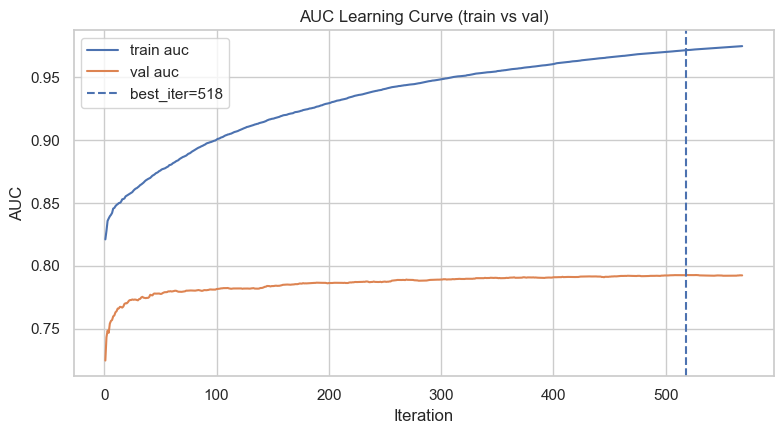

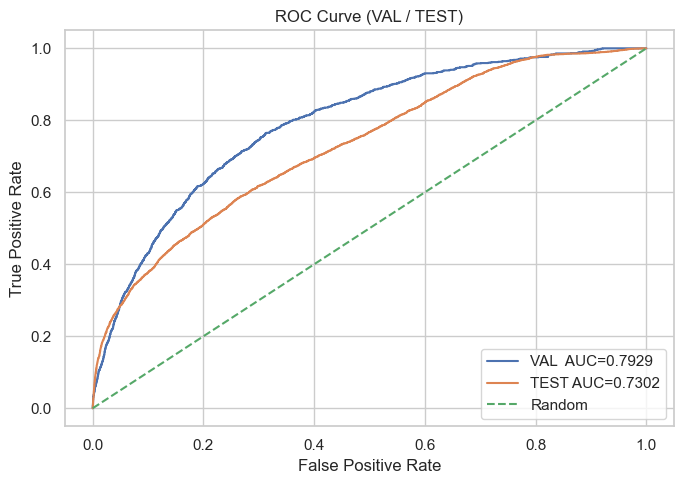

[POLICY EVAL] life_weighted min_prob (row-wise thr)
[VAL ] P/R/F1=0.0000/0.0000/0.0000 | CM tn=42,753 fp=0 fn=1,124 tp=0 | alarms_total=0 alarms/hour=0.000 alarms/day=0.0
[TEST] P/R/F1=0.0000/0.0000/0.0000 | CM tn=92,706 fp=0 fn=3,609 tp=0 | alarms_total=0 alarms/hour=0.000 alarms/day=0.0

[SUMMARY]


,FH,y_mean,val_auc,test_auc,val_pr_auc,test_pr_auc,VAL_precision,VAL_recall,VAL_f1,VAL_alarms/hour,VAL_alarms/day,TEST_precision,TEST_recall,TEST_f1,TEST_alarms/hour,TEST_alarms/day
0,1,0.043398,0.792852,0.730163,0.113289,0.155647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# ============================================
# [CELL10 v3] B-rule LightGBM + Track A(수명가중 임계값)
#  - 라벨: event_stream_v2에서 trigger=B + problem_group=sparepart만 사용
#  - 모델: LightGBM로 "1시간 내 fail_event(=B-rule 이벤트)" 위험도 점수 산출
#  - 정책: life_ratio 기반 동적 min_prob(threshold) 적용
#
# (중요) Track A 테이블 컬럼은 자동 탐지(fallback 포함)
# ============================================

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from datetime import date, time

import numpy as np
import pandas as pd
from sqlalchemy import text
from sqlalchemy.engine import Engine

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support

# --- [ADD] plotting ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# =========================
# (0) CONFIG
# =========================
ML_SCHEMA   = "h_machine_learning"
EVT_SCHEMA  = "h_machine_learning"
EVT_TABLE   = "event_stream_v2"
STATE_TABLE = "etl_state_cell10_v2"
STATE_KEY   = "cell10_event_stream_v2"

SRC_SCHEMA  = "f_database"
SRC_TABLE   = "fct_database"

MAP_SCHEMA  = "f_database"
MAP_TABLE   = "step_description_problem"

# feature_store
FS_SCHEMA   = "h_machine_learning"
FS_TABLE    = "1_database_house"

# Track A (수명)
LIFE_SCHEMA = "e3_sparepart_replacement"
LIFE_TABLE  = "sparepart_life_amount"

# 기간
DATE_FROM = pd.Timestamp("2025-09-27")
DATE_TO   = pd.Timestamp("2025-12-05")

# 라벨 horizon
FH = 1  # 1시간

# event build
FETCH_LIMIT = 200_000
FORCE_REBUILD_EVENT_STREAM = False

# B-rule(3% 이상 FAIL) 관련
B_RATE_THRESHOLD = 0.03
PROMO_WINDOW_HOURS = 12
MAX_LEVEL = 4

# shift 정의
DAY_START = time(8, 30, 0)
DAY_END   = time(20, 29, 59)

# A-rule은 폐기(희소)
USE_A_RULE = False

# "problem2/3/4가 equipment이면 알람 제외"를 event 생성 단계에서 반영할지 여부
# True면: level>=2에서 pv=="equipment"인 이벤트는 아예 생성/학습 라벨에서 제거됨
SILENT_EXCLUDE_EQUIPMENT_LV2P = True

# 모델 학습 split
VAL_DAYS  = 7
TEST_DAYS = 14
MIN_TRAIN_DAYS = 21

# =========================
# (1) 정책: 수명가중 임계값(동적 min_prob)
# =========================
LIFE_THR_RULES = [
    # (min_ratio_inclusive, min_prob)
    (0.00, 0.90),
    (0.50, 0.70),
    (0.70, 0.55),
    (0.90, 0.35),
    (1.00, 0.25),
]

def min_prob_by_life_ratio(r: float) -> float:
    if r is None or not np.isfinite(r):
        return LIFE_THR_RULES[0][1]
    r = float(r)
    thr = LIFE_THR_RULES[0][1]
    for ratio0, mp in LIFE_THR_RULES:
        if r >= ratio0:
            thr = mp
    return float(thr)

# =========================
# (2) UTIL
# =========================
def _now() -> pd.Timestamp:
    return pd.Timestamp.now()

def _fmt_sec(sec: float) -> str:
    if sec < 60:
        return f"{sec:.2f}s"
    if sec < 3600:
        return f"{sec/60:.2f}m"
    return f"{sec/3600:.2f}h"

def _shift_of(ts: pd.Timestamp) -> Tuple[str, date]:
    t = ts.time()
    if DAY_START <= t <= DAY_END:
        return "DAY", ts.date()
    if t >= time(20,30,0):
        return "NIGHT", ts.date()
    return "NIGHT", (ts - pd.Timedelta(days=1)).date()

def _get_cols(engine: Engine, schema: str, table: str) -> List[str]:
    q = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema=:s AND table_name=:t
    ORDER BY ordinal_position
    """
    with engine.connect() as conn:
        rows = conn.execute(text(q), {"s": schema, "t": table}).fetchall()
    return [r[0] for r in rows]

def _get_col_meta(engine: Engine, schema: str, table: str) -> Dict[str, dict]:
    q = """
    SELECT column_name, is_nullable, data_type
    FROM information_schema.columns
    WHERE table_schema=:s AND table_name=:t
    """
    with engine.connect() as conn:
        rows = conn.execute(text(q), {"s": schema, "t": table}).fetchall()
    meta = {}
    for c, is_nullable, data_type in rows:
        meta[c] = {
            "notnull": (str(is_nullable).upper() == "NO"),
            "data_type": str(data_type).lower(),
        }
    return meta

def _default_by_type(data_type: str):
    dt = (data_type or "").lower()
    if "int" in dt:
        return 0
    if dt in ("numeric", "decimal", "real", "double precision"):
        return 0.0
    if "timestamp" in dt:
        return None
    if dt == "date":
        return None
    if dt == "boolean":
        return False
    return ""

def _safe_auc(y, p):
    y = np.asarray(y)
    if len(np.unique(y)) < 2:
        return np.nan
    return roc_auc_score(y, p)

def _confusion_counts(y_true, y_prob, thr):
    y_true = np.asarray(y_true).astype(int)
    y_hat  = (np.asarray(y_prob, dtype=float) >= float(thr)).astype(int)
    tp = int(((y_true == 1) & (y_hat == 1)).sum())
    fp = int(((y_true == 0) & (y_hat == 1)).sum())
    tn = int(((y_true == 0) & (y_hat == 0)).sum())
    fn = int(((y_true == 1) & (y_hat == 0)).sum())
    return tp, fp, tn, fn

def _prf(tp, fp, fn):
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    return float(prec), float(rec), float(f1)

# =========================
# (2-1) [ADD] Plot helpers (Seaborn styled)
# =========================
def _sns_style():
    try:
        sns.set_theme(style="whitegrid")
    except Exception:
        pass

def plot_roc_curves(yva, pva, yte, pte, val_auc: float, test_auc: float):
    _sns_style()
    fpr_v, tpr_v, _ = roc_curve(yva, pva)
    fpr_t, tpr_t, _ = roc_curve(yte, pte)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr_v, tpr_v, label=f"VAL  AUC={val_auc:.4f}")
    plt.plot(fpr_t, tpr_t, label=f"TEST AUC={test_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (VAL / TEST)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

def plot_auc_learning_curve(evals_result: dict, best_iter: int):
    _sns_style()
    tr_auc = evals_result.get("train", {}).get("auc", None)
    va_auc = evals_result.get("val", {}).get("auc", None)

    if not tr_auc or not va_auc:
        print("[WARN] evals_result에 auc 기록이 없습니다. lgb.record_evaluation(evals_result) 콜백을 확인하세요.")
        return

    iters = np.arange(1, len(tr_auc) + 1)

    plt.figure(figsize=(8, 4.5))
    plt.plot(iters, tr_auc, label="train auc")
    plt.plot(iters, va_auc, label="val auc")
    if best_iter is not None and best_iter > 0:
        plt.axvline(int(best_iter), linestyle="--", label=f"best_iter={best_iter}")
    plt.xlabel("Iteration")
    plt.ylabel("AUC")
    plt.title("AUC Learning Curve (train vs val)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# =========================
# (3) event_stream_v2 ensure + state
# =========================
def ensure_event_stream_v2(engine: Engine):
    ddl_create = f"""
    CREATE TABLE IF NOT EXISTS "{EVT_SCHEMA}"."{EVT_TABLE}" (
        id BIGSERIAL PRIMARY KEY,
        event_ts TIMESTAMP NOT NULL,
        trigger_type TEXT NOT NULL,
        level INTEGER NOT NULL,

        problem_level INTEGER NOT NULL DEFAULT 1,
        action_type TEXT NOT NULL DEFAULT 'UNKNOWN',

        station TEXT NOT NULL,
        remark TEXT NOT NULL,
        shift_name TEXT NOT NULL,
        shift_date DATE NOT NULL,

        step_description TEXT,
        step_description_nn TEXT NOT NULL DEFAULT '',

        problem_value TEXT,
        problem_group TEXT,

        metric_fail_streak INTEGER NOT NULL DEFAULT 0,
        metric_fail_rate DOUBLE PRECISION NOT NULL DEFAULT 0.0,

        promo_count INTEGER NOT NULL DEFAULT 0,

        base_key TEXT NOT NULL DEFAULT '',
        trig_rule TEXT NOT NULL DEFAULT '',
        a_consec INTEGER NOT NULL DEFAULT 0,
        b_fail_rate DOUBLE PRECISION NOT NULL DEFAULT 0.0,
        recurrence_count INTEGER NOT NULL DEFAULT 0,
        created_at TIMESTAMP NOT NULL DEFAULT NOW(),
        updated_at TIMESTAMP NOT NULL DEFAULT NOW()
    )
    """
    ddl_uq = f"""
    CREATE UNIQUE INDEX IF NOT EXISTS event_stream_v2_uq
    ON "{EVT_SCHEMA}"."{EVT_TABLE}"
    (event_ts, trigger_type, level, station, remark, shift_name, shift_date, step_description_nn)
    """
    with engine.begin() as conn:
        conn.execute(text(ddl_create))
        conn.execute(text(ddl_uq))

def ensure_state_table_v2(engine: Engine):
    ddl_create = f"""
    CREATE TABLE IF NOT EXISTS "{ML_SCHEMA}"."{STATE_TABLE}" (
        "key" TEXT PRIMARY KEY,
        cursor_end_ts TIMESTAMP NOT NULL,
        cursor_group_i BIGINT NOT NULL DEFAULT 0,
        updated_at TIMESTAMP NOT NULL DEFAULT NOW()
    )
    """
    with engine.begin() as conn:
        conn.execute(text(ddl_create))

@dataclass
class CursorState:
    end_ts: pd.Timestamp
    grp_i: int

def load_state(engine: Engine, key: str) -> Optional[CursorState]:
    q = f"""
    SELECT cursor_end_ts, cursor_group_i
    FROM "{ML_SCHEMA}"."{STATE_TABLE}"
    WHERE "key"=:k
    """
    with engine.connect() as conn:
        r = conn.execute(text(q), {"k": key}).fetchone()
    if not r or r[0] is None:
        return None
    return CursorState(pd.to_datetime(r[0]), int(r[1] or 0))

def save_state(engine: Engine, key: str, st: CursorState):
    q = f"""
    INSERT INTO "{ML_SCHEMA}"."{STATE_TABLE}" ("key", cursor_end_ts, cursor_group_i, updated_at)
    VALUES (:k, :ts, :gi, NOW())
    ON CONFLICT ("key")
    DO UPDATE SET cursor_end_ts=EXCLUDED.cursor_end_ts, cursor_group_i=EXCLUDED.cursor_group_i, updated_at=NOW()
    """
    with engine.begin() as conn:
        conn.execute(text(q), {"k": key, "ts": st.end_ts.to_pydatetime(), "gi": int(st.grp_i)})

def reset_event_stream_range(engine: Engine, d0: pd.Timestamp, d1: pd.Timestamp):
    with engine.begin() as conn:
        conn.execute(
            text(f'DELETE FROM "{EVT_SCHEMA}"."{EVT_TABLE}" WHERE event_ts >= :t0 AND event_ts < :t1'),
            {"t0": d0.to_pydatetime(), "t1": (d1 + pd.Timedelta(days=1)).to_pydatetime()},
        )
        conn.execute(text(f'DELETE FROM "{ML_SCHEMA}"."{STATE_TABLE}" WHERE "key"=:k'), {"k": STATE_KEY})

# =========================
# (4) step_description -> problem1..4 mapping
# =========================
def load_step_problem_map(engine: Engine) -> Dict[str, Tuple[Optional[str],Optional[str],Optional[str],Optional[str]]]:
    cols = set(_get_cols(engine, MAP_SCHEMA, MAP_TABLE))
    need = {"step_description","problem1","problem2","problem3","problem4"}
    missing = sorted(list(need - cols))
    if missing:
        raise RuntimeError(f"[CELL10] step_description_problem missing required columns: {missing}")

    q = f"""
    SELECT step_description, problem1, problem2, problem3, problem4
    FROM "{MAP_SCHEMA}"."{MAP_TABLE}"
    """
    with engine.connect() as conn:
        df = pd.read_sql(text(q), conn)

    df["step_description"] = df["step_description"].astype(str).str.strip()
    for c in ["problem1","problem2","problem3","problem4"]:
        df[c] = df[c].astype(str).str.strip().str.lower().replace({"nan": None, "": None})

    mp: Dict[str, Tuple[Optional[str],Optional[str],Optional[str],Optional[str]]] = {}
    for _, r in df.iterrows():
        mp[r["step_description"]] = (r["problem1"], r["problem2"], r["problem3"], r["problem4"])
    return mp

# =========================
# (5) Raw fetch SQL (cursor)
# =========================
def build_cursor_sql() -> str:
    q = f"""
    WITH base AS (
        SELECT
            (end_day::date + end_time::time) AS end_ts,
            "group"::bigint AS grp_i,
            station::text AS station,
            remark::text AS remark,
            step_description::text AS step_description,
            result::text AS result,
            value AS value
        FROM "{SRC_SCHEMA}"."{SRC_TABLE}"
        WHERE
            (end_day::date + end_time::time) >= :t0
            AND (end_day::date + end_time::time) <  :t1
            AND (
                (end_day::date + end_time::time) > :c_ts
                OR (
                    (end_day::date + end_time::time) = :c_ts
                    AND "group"::bigint > :c_gi
                )
            )
    )
    SELECT *
    FROM base
    ORDER BY end_ts ASC, grp_i ASC
    LIMIT :lim
    """
    return q

# =========================
# (6) Event helpers
# =========================
SPAREPART_SET = {"usb_a","usb_c","mini_b","probe_pin","passmark","pd_board","relay_board"}

def _problem_group(problem_value: Optional[str]) -> Optional[str]:
    if problem_value is None:
        return None
    pv = str(problem_value).strip().lower()
    if pv == "" or pv == "nan":
        return None
    if pv == "product":
        return "product"
    if pv in SPAREPART_SET:
        return "sparepart"
    if pv == "equipment":
        return "equipment"
    return "equipment"

def _action_type(problem_group: Optional[str]) -> str:
    if problem_group == "sparepart":
        return "SPAREPART_CHANGE"
    if problem_group == "equipment":
        return "EQUIPMENT_REVIEW"
    return "UNKNOWN"

def _promote_level(last_level: int) -> int:
    return int(min(MAX_LEVEL, last_level + 1))

def _norm_step_desc(step_desc) -> Tuple[Optional[str], str]:
    step_desc = None if pd.isna(step_desc) else str(step_desc)
    payload_step = None if step_desc is None else step_desc
    step_desc_nn = "" if payload_step is None else str(payload_step)
    return payload_step, step_desc_nn

def _make_base_key(station: str, remark: str, shift_name: str, shift_date: date, step_desc_nn: str, trigger_type: str) -> str:
    return f"{station}|{remark}|{shift_name}|{shift_date.isoformat()}|{trigger_type}|{step_desc_nn}"

def _get_last_event(engine: Engine, trigger_type: str, station: str, remark: str, shift_name: str, shift_date: date) -> Optional[Tuple[pd.Timestamp,int,int]]:
    q = f"""
    SELECT event_ts, level, promo_count
    FROM "{EVT_SCHEMA}"."{EVT_TABLE}"
    WHERE trigger_type=:tt
      AND station=:st AND remark=:rm
      AND shift_name=:sn AND shift_date=:sd
    ORDER BY event_ts DESC
    LIMIT 1
    """
    with engine.connect() as conn:
        r = conn.execute(
            text(q),
            {"tt": trigger_type, "st": station, "rm": remark, "sn": shift_name, "sd": shift_date}
        ).fetchone()
    if not r:
        return None
    return (pd.to_datetime(r[0]), int(r[1]), int(r[2]))

def _insert_events(engine: Engine, rows: List[dict]):
    if not rows:
        return

    cols_in_table = _get_cols(engine, EVT_SCHEMA, EVT_TABLE)
    meta = _get_col_meta(engine, EVT_SCHEMA, EVT_TABLE)

    for r in rows:
        event_ts = r.get("event_ts")
        for c, m in meta.items():
            if c in ("id", "updated_at"):
                continue
            if not m["notnull"]:
                continue
            if c not in r or r[c] is None:
                dt = m["data_type"]
                if "timestamp" in dt:
                    r[c] = event_ts
                    continue
                if dt == "date":
                    if c == "shift_date":
                        r["shift_date"] = r.get("shift_date") or DATE_FROM.date()
                        continue
                    r[c] = DATE_FROM.date()
                    continue
                if c == "problem_level":
                    r[c] = int(r.get("level", 1) or 1)
                    continue
                if c == "action_type":
                    r[c] = str(r.get("action_type") or "UNKNOWN")
                    continue
                if c == "step_description_nn":
                    r[c] = "" if r.get("step_description") is None else str(r.get("step_description"))
                    continue
                if c == "promo_count":
                    r[c] = int(r.get("promo_count", 0) or 0)
                    continue
                if c == "metric_fail_streak":
                    r[c] = int(r.get("metric_fail_streak", 0) or 0)
                    continue
                if c == "metric_fail_rate":
                    r[c] = float(r.get("metric_fail_rate", 0.0) or 0.0)
                    continue
                if c == "recurrence_count":
                    r[c] = int(r.get("recurrence_count", r.get("promo_count", 0)) or 0)
                    continue

                base = _default_by_type(dt)
                r[c] = (event_ts if base is None else base)

    use_cols = [c for c in cols_in_table if c in rows[0] and c not in ("id", "updated_at")]
    col_sql = ", ".join([f'"{c}"' for c in use_cols])
    val_sql = ", ".join([f":{c}" for c in use_cols])

    ins = f"""
    INSERT INTO "{EVT_SCHEMA}"."{EVT_TABLE}" ({col_sql}, updated_at)
    VALUES ({val_sql}, NOW())
    ON CONFLICT DO NOTHING
    """
    with engine.begin() as conn:
        conn.execute(text(ins), rows)

# =========================
# (7) Build event_stream_v2 (B-rule only)
# =========================
def build_event_stream_cursor_incremental(engine: Engine):
    ensure_event_stream_v2(engine)
    ensure_state_table_v2(engine)

    if FORCE_REBUILD_EVENT_STREAM:
        print(f"[EVENT_STREAM] FORCE_REBUILD_EVENT_STREAM=True -> clear range + reset state")
        reset_event_stream_range(engine, DATE_FROM, DATE_TO)
        save_state(engine, STATE_KEY, CursorState(end_ts=DATE_FROM - pd.Timedelta(seconds=1), grp_i=0))

    st = load_state(engine, STATE_KEY)
    if st is None:
        st = CursorState(end_ts=DATE_FROM - pd.Timedelta(seconds=1), grp_i=0)
        save_state(engine, STATE_KEY, st)

    mp_map = load_step_problem_map(engine)

    q = build_cursor_sql()
    t0 = DATE_FROM
    t1 = DATE_TO + pd.Timedelta(days=1)

    cursor_ts = st.end_ts
    cursor_gi = st.grp_i

    total_rows = 0
    total_events = 0
    t_start = _now()

    b_state: Dict[Tuple[str,str,str,date,str], Tuple[int,int,Optional[pd.Timestamp]]] = {}

    while True:
        params = {
            "t0": t0.to_pydatetime(),
            "t1": t1.to_pydatetime(),
            "c_ts": cursor_ts.to_pydatetime(),
            "c_gi": int(cursor_gi),
            "lim": int(FETCH_LIMIT),
        }
        with engine.connect() as conn:
            df = pd.read_sql(text(q), conn, params=params)

        if df is None or len(df) == 0:
            break

        df["end_ts"] = pd.to_datetime(df["end_ts"], errors="coerce")
        df["station"] = df["station"].astype(str)
        df["remark"] = df["remark"].astype(str)
        df["step_description"] = df["step_description"].astype(str).str.strip()
        df["result"] = df["result"].astype(str).str.upper()

        ev_rows: List[dict] = []

        for _, rr in df.iterrows():
            ts = rr["end_ts"]
            if pd.isna(ts):
                continue

            station = str(rr["station"])
            remark  = str(rr["remark"])
            step_desc_raw = str(rr["step_description"]).strip()
            result = str(rr["result"]).upper()

            shift_name, shift_date = _shift_of(ts)
            key = (station, remark, shift_name, shift_date, step_desc_raw)

            p1, p2, p3, p4 = mp_map.get(step_desc_raw, (None, None, None, None))

            total_cnt, fail_cnt, last_trig_ts = b_state.get(key, (0, 0, None))
            if last_trig_ts is not None and ts > last_trig_ts:
                total_cnt, fail_cnt = (0, 0)
                last_trig_ts = None

            total_cnt += 1
            if result == "FAIL":
                fail_cnt += 1
            rate = (fail_cnt / total_cnt) if total_cnt > 0 else 0.0

            if rate > B_RATE_THRESHOLD:
                last = _get_last_event(engine, "B", station, remark, shift_name, shift_date)
                level = 1
                promo_count = 0
                if last is not None:
                    last_ts, last_lv, last_pc = last
                    if ts <= last_ts + pd.Timedelta(hours=PROMO_WINDOW_HOURS):
                        level = _promote_level(last_lv)
                        promo_count = last_pc + 1

                pv = {1: p1, 2: p2, 3: p3, 4: p4}.get(level, p4)
                pg = _problem_group(pv)

                if pg == "product":
                    b_state[key] = (int(total_cnt), int(fail_cnt), last_trig_ts)
                    continue

                if SILENT_EXCLUDE_EQUIPMENT_LV2P and int(level) >= 2 and (pv == "equipment" or pg == "equipment"):
                    last_trig_ts = ts
                    b_state[key] = (int(total_cnt), int(fail_cnt), last_trig_ts)
                    continue

                step_desc, step_desc_nn = _norm_step_desc(step_desc_raw)

                base_key = _make_base_key(station, remark, shift_name, shift_date, step_desc_nn, "B")
                trig_rule = "B_rate>0.03"
                a_consec = 0
                b_fail_rate = rate
                recurrence_count = promo_count
                created_at = ts.to_pydatetime()

                ev_rows.append({
                    "event_ts": ts.to_pydatetime(),
                    "trigger_type": "B",
                    "level": int(level),

                    "problem_level": int(level),
                    "problem_value": pv,
                    "action_type": _action_type(pg),

                    "station": station,
                    "remark": remark,
                    "shift_name": shift_name,
                    "shift_date": shift_date,

                    "step_description": step_desc,
                    "step_description_nn": step_desc_nn,

                    "problem_group": pg if pg in ("sparepart","equipment") else "equipment",

                    "metric_fail_streak": int(0),
                    "metric_fail_rate": float(rate),
                    "promo_count": int(promo_count),

                    "base_key": base_key,
                    "trig_rule": trig_rule,
                    "a_consec": int(a_consec),
                    "b_fail_rate": float(b_fail_rate),
                    "recurrence_count": int(recurrence_count),
                    "created_at": created_at,
                })
                total_events += 1
                last_trig_ts = ts

            b_state[key] = (int(total_cnt), int(fail_cnt), last_trig_ts)

        _insert_events(engine, ev_rows)

        total_rows += len(df)
        last_ts = pd.to_datetime(df.iloc[-1]["end_ts"])
        last_gi = int(df.iloc[-1]["grp_i"])
        cursor_ts, cursor_gi = last_ts, last_gi
        save_state(engine, STATE_KEY, CursorState(end_ts=cursor_ts, grp_i=cursor_gi))

        print(f"[BATCH] rows={len(df):,} | new_events={len(ev_rows):,} | cursor=({cursor_ts}, {cursor_gi}) | elapsed={_fmt_sec((_now()-t_start).total_seconds())}")

    print(f"[DONE] event_stream_v2 build | total_rows={total_rows:,} | total_events={total_events:,} | elapsed={_fmt_sec((_now()-t_start).total_seconds())}")

# =========================
# (8) Load events for labeling
# =========================
def load_event_stream(engine: Engine, trigger_type: str="B", pg_filter: Optional[str]="sparepart") -> pd.DataFrame:
    q = f"""
    SELECT event_ts, trigger_type, level, station, remark, problem_value, problem_group, step_description_nn
    FROM "{EVT_SCHEMA}"."{EVT_TABLE}"
    WHERE event_ts >= :t0 AND event_ts < :t1
      AND trigger_type = :tt
    """
    with engine.connect() as conn:
        df = pd.read_sql(
            text(q), conn,
            params={"t0": DATE_FROM.to_pydatetime(), "t1": (DATE_TO + pd.Timedelta(days=1)).to_pydatetime(), "tt": trigger_type}
        )
    df["event_ts"] = pd.to_datetime(df["event_ts"], errors="coerce")
    df["station"] = df["station"].astype(str)
    df["remark"] = df["remark"].astype(str)
    if "problem_group" in df.columns:
        df["problem_group"] = df["problem_group"].astype(str).str.lower()
    if pg_filter is not None and "problem_group" in df.columns:
        df = df[df["problem_group"] == str(pg_filter).lower()].copy()
    return df.dropna(subset=["event_ts"])

def make_y_future_from_events(df_all: pd.DataFrame, ev_df: pd.DataFrame, future_hours: int) -> pd.Series:
    if len(df_all) == 0:
        return pd.Series(dtype=int)

    df_all2 = df_all.copy()
    df_all2["end_ts"] = pd.to_datetime(df_all2["end_ts"], errors="coerce")
    df_all2 = df_all2.dropna(subset=["end_ts"]).copy()

    df_all2["station"] = df_all2["station"].astype(str)
    df_all2["remark"]  = df_all2["remark"].astype(str)

    groups = {}
    for (st, rm), g in ev_df.groupby(["station", "remark"], dropna=False):
        ev_ns = pd.to_datetime(g["event_ts"], errors="coerce").dropna().values.astype("datetime64[ns]").astype("int64")
        ev_ns.sort()
        groups[(str(st), str(rm))] = ev_ns

    horizon = int(future_hours) * 3600 * 1_000_000_000  # ns
    y = np.zeros(len(df_all2), dtype=np.int8)

    end_ns = df_all2["end_ts"].values.astype("datetime64[ns]").astype("int64")

    for i in range(len(df_all2)):
        arr = groups.get((df_all2.iloc[i]["station"], df_all2.iloc[i]["remark"]))
        if arr is None or arr.size == 0:
            continue
        t0 = end_ns[i]
        t1 = t0 + horizon
        j = np.searchsorted(arr, t0, side="left")
        if j < arr.size and arr[j] <= t1:
            y[i] = 1

    out = pd.Series(0, index=df_all.index, dtype=np.int8)
    out.loc[df_all2.index] = y
    return out

# =========================
# (9) Split
# =========================
def split_by_days_auto(df: pd.DataFrame, val_days: int, test_days: int, min_train: int):
    days = sorted(pd.to_datetime(df["end_day"]).dt.date.unique())
    need_min = val_days + test_days + min_train
    if len(days) < need_min:
        raise ValueError(f"[SPLIT FAIL] unique_days={len(days)} < (min_train+val+test)={need_min}")

    train_days = len(days) - (val_days + test_days)
    train_days = max(min_train, train_days)

    train_set = set(days[:train_days])
    val_set   = set(days[train_days:train_days+val_days])
    test_set  = set(days[train_days+val_days:train_days+val_days+test_days])

    tr = df[pd.to_datetime(df["end_day"]).dt.date.isin(train_set)].copy()
    va = df[pd.to_datetime(df["end_day"]).dt.date.isin(val_set)].copy()
    te = df[pd.to_datetime(df["end_day"]).dt.date.isin(test_set)].copy()

    info = {
        "unique_days": len(days),
        "train_days": train_days,
        "val_days": val_days,
        "test_days": test_days,
        "train_n": len(tr),
        "val_n": len(va),
        "test_n": len(te),
        "train_pos": int(tr["y_future"].sum()),
        "val_pos": int(va["y_future"].sum()),
        "test_pos": int(te["y_future"].sum()),
    }
    return tr, va, te, info

# =========================
# (10) Track A 수명 테이블 로드 + life_ratio 산출
# =========================
def load_trackA_life(engine: Engine) -> pd.DataFrame:
    cols = _get_cols(engine, LIFE_SCHEMA, LIFE_TABLE)
    cols_l = [c.lower() for c in cols]

    def pick(*cands):
        for cand in cands:
            if cand.lower() in cols_l:
                return cols[cols_l.index(cand.lower())]
        return None

    c_station = pick("station", "station_name", "line", "equip", "equipment", "machine")
    c_sp      = pick("sparepart", "spare_part", "part", "part_name")
    c_p25     = pick("p25", "p_25", "life_p25", "life_amount_p25", "allow_cycle_p25")
    c_cc      = pick("cycle_count_since_last_change", "cycle_count", "cycle_cnt", "count_since_change", "life_cycle_count")

    sel_cols = [c for c in [c_station, c_sp, c_p25, c_cc] if c is not None]
    if not sel_cols:
        return pd.DataFrame()

    q = f'SELECT {", ".join([f"""\"{c}\"""" for c in sel_cols])} FROM "{LIFE_SCHEMA}"."{LIFE_TABLE}"'
    with engine.connect() as conn:
        df = pd.read_sql(text(q), conn)

    if c_station is not None:
        df["station__life"] = df[c_station].astype(str)
    else:
        df["station__life"] = ""

    if c_sp is not None:
        df["sparepart__life"] = df[c_sp].astype(str).str.lower()
    else:
        df["sparepart__life"] = ""

    if c_p25 is not None:
        df["p25__life"] = pd.to_numeric(df[c_p25], errors="coerce")
    else:
        df["p25__life"] = np.nan

    if c_cc is not None:
        df["cycle__life"] = pd.to_numeric(df[c_cc], errors="coerce")
    else:
        df["cycle__life"] = np.nan

    df = df.dropna(subset=["p25__life"]).copy()
    df["life_ratio"] = df["cycle__life"] / df["p25__life"]
    df["life_ratio"] = df["life_ratio"].replace([np.inf, -np.inf], np.nan)

    agg = df.groupby("station__life").agg(
        life_ratio_max=("life_ratio", "max"),
        life_ratio_min=("life_ratio", "min"),
        life_ratio_mean=("life_ratio", "mean"),
        p25_min=("p25__life", "min"),
        p25_max=("p25__life", "max"),
    ).reset_index().rename(columns={"station__life":"station"})

    return agg

def attach_life_ratio(df_all: pd.DataFrame, life_station_df: pd.DataFrame) -> pd.DataFrame:
    out = df_all.copy()
    out["station"] = out["station"].astype(str)
    if life_station_df is None or len(life_station_df) == 0:
        out["life_ratio_max"] = 0.0
        return out
    out = out.merge(life_station_df[["station","life_ratio_max"]], on="station", how="left")
    out["life_ratio_max"] = pd.to_numeric(out["life_ratio_max"], errors="coerce").fillna(0.0)
    return out

# =========================
# (11) 정책 적용 평가 (수명가중 임계값)
# =========================
def eval_with_life_weighted_threshold(df_split: pd.DataFrame, prob: np.ndarray, life_ratio_col: str="life_ratio_max"):
    y = df_split["y_future"].astype(int).values
    life = pd.to_numeric(df_split.get(life_ratio_col, 0.0), errors="coerce").fillna(0.0).values

    thr_vec = np.array([min_prob_by_life_ratio(r) for r in life], dtype=float)
    yhat = (np.asarray(prob, dtype=float) >= thr_vec).astype(int)

    tp = int(((y==1) & (yhat==1)).sum())
    fp = int(((y==0) & (yhat==1)).sum())
    tn = int(((y==0) & (yhat==0)).sum())
    fn = int(((y==1) & (yhat==0)).sum())
    prec, rec, f1 = _prf(tp, fp, fn)

    alarms_total = int(tp + fp)
    split_days = float(pd.to_datetime(df_split["end_day"]).dt.date.nunique())
    hours = split_days * 24.0
    alarms_per_hour = alarms_total / hours if hours > 0 else np.nan
    alarms_per_day  = alarms_total / split_days if split_days > 0 else np.nan

    return {
        "precision": prec, "recall": rec, "f1": f1,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn,
        "alarms_total": alarms_total,
        "alarms/hour": float(alarms_per_hour),
        "alarms/day": float(alarms_per_day),
        "split_days": split_days,
    }

# =========================
# (12) MAIN: CELL10 실행
# =========================
def run_cell10_trackA_weighted(engine: Engine):
    print("="*110)
    print("[CELL10 v3] B-rule LGBM + TrackA(수명가중 임계값) | FH=1")
    print(f"DATE_FROM={DATE_FROM} | DATE_TO={DATE_TO} | FETCH_LIMIT={FETCH_LIMIT:,}")
    print(f"FORCE_REBUILD_EVENT_STREAM={FORCE_REBUILD_EVENT_STREAM} | SILENT_EXCLUDE_EQUIPMENT_LV2P={SILENT_EXCLUDE_EQUIPMENT_LV2P}")
    print(f"LIFE_THR_RULES={LIFE_THR_RULES}")
    print("="*110)

    # 1) build events
    t0 = _now()
    build_event_stream_cursor_incremental(engine)
    print(f"[EVENT_STREAM] build done | elapsed={_fmt_sec((_now()-t0).total_seconds())}")

    # 2) load feature_store
    q_fs = f"""
    SELECT *
    FROM "{FS_SCHEMA}"."{FS_TABLE}"
    WHERE end_day::date >= :d0 AND end_day::date <= :d1
    """
    t1 = _now()
    with engine.connect() as conn:
        df_all = pd.read_sql(text(q_fs), conn, params={"d0": DATE_FROM.date(), "d1": DATE_TO.date()})

    # end_ts 정규화
    if "end_ts" not in df_all.columns:
        df_all["end_ts"] = pd.to_datetime(df_all["end_day"], errors="coerce") + pd.to_timedelta(df_all["end_time"].astype(str), errors="coerce")
    else:
        df_all["end_ts"] = pd.to_datetime(df_all["end_ts"], errors="coerce")

    df_all = df_all.dropna(subset=["end_ts"]).reset_index(drop=True)

    print(f"[LOAD] feature_store rows={len(df_all):,} cols={df_all.shape[1]} | elapsed={_fmt_sec((_now()-t1).total_seconds())}")

    # 3) load events for labeling (B + sparepart)
    ev_df = load_event_stream(engine, trigger_type="B", pg_filter="sparepart")
    print(f"[LOAD] events rows={len(ev_df):,} | label_trigger=B | pg_filter=sparepart")

    # 4) Track A life load + attach
    life_station_df = load_trackA_life(engine)
    df_all = attach_life_ratio(df_all, life_station_df)
    print(f"[TRACK-A] life_station rows={len(life_station_df):,} | attached col=life_ratio_max")

    # 5) feature columns
    drop_cols = {"y","y_future","end_day","end_time","end_ts","station","remark","shift_name","shift_date","barcode_information","grp","group","bin"}
    feature_cols = [c for c in df_all.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(df_all[c])]
    if "life_ratio_max" in df_all.columns and "life_ratio_max" not in feature_cols:
        feature_cols.append("life_ratio_max")

    print(f"[FEATURE] used={len(feature_cols)}")
    if len(feature_cols):
        print("[FEATURE] first =", feature_cols[:12])

    # 6) label 생성 (FH=1)
    df_all2 = df_all.copy()
    df_all2["y_future"] = make_y_future_from_events(df_all2, ev_df, future_hours=FH).astype(int)
    y_mean = float(df_all2["y_future"].mean())
    print(f"[LABEL] FH={FH} y_mean={y_mean:.6f}")

    # 7) split
    tr, va, te, info = split_by_days_auto(df_all2, val_days=VAL_DAYS, test_days=TEST_DAYS, min_train=MIN_TRAIN_DAYS)
    print("[SPLIT]", info)

    def XY(d):
        X = d[feature_cols].fillna(0.0)
        y = d["y_future"].astype(int)
        return X, y

    Xtr, ytr = XY(tr)
    Xva, yva = XY(va)
    Xte, yte = XY(te)

    if int(ytr.sum()) < 50:
        raise RuntimeError(f"train_pos too small: {int(ytr.sum())}")

    # 8) train LGBM
    print("="*110)
    print("[TRAIN] LightGBM (B-rule)")
    print("="*110)

    dtr = lgb.Dataset(Xtr, label=ytr)
    dva = lgb.Dataset(Xva, label=yva, reference=dtr)

    params = dict(
        objective="binary",
        metric="auc",
        learning_rate=0.05,
        num_leaves=63,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        seed=42,
        verbosity=-1,
    )

    # --- [ADD] evals_result 기록 ---
    evals_result = {}

    t2 = _now()
    model = lgb.train(
        params,
        dtr,
        valid_sets=[dtr, dva],
        valid_names=["train","val"],
        num_boost_round=2000,
        callbacks=[
            lgb.early_stopping(50, verbose=True),
            lgb.record_evaluation(evals_result),
        ]
    )
    print(f"[TRAIN] done | best_iter={int(model.best_iteration)} | elapsed={_fmt_sec((_now()-t2).total_seconds())}")

    pva = model.predict(Xva, num_iteration=model.best_iteration)
    pte = model.predict(Xte, num_iteration=model.best_iteration)

    # 9) 기본 지표(AUC/PR)
    val_auc = _safe_auc(yva, pva)
    test_auc = _safe_auc(yte, pte)
    val_pr  = average_precision_score(yva, pva) if yva.sum() > 0 else np.nan
    test_pr = average_precision_score(yte, pte) if yte.sum() > 0 else np.nan

    print(f"[METRIC] AUC val={val_auc:.6f} | test={test_auc:.6f}")
    print(f"[METRIC] PR  val={val_pr:.6f} | test={test_pr:.6f}")

    # --- [ADD] AUC 그래프 출력 (seaborn styled) ---
    plot_auc_learning_curve(evals_result, best_iter=int(model.best_iteration))
    plot_roc_curves(yva.values, pva, yte.values, pte, float(val_auc), float(test_auc))

    # 10) 정책 평가: 수명가중 임계값 적용
    print("="*110)
    print("[POLICY EVAL] life_weighted min_prob (row-wise thr)")
    print("="*110)

    out_va = eval_with_life_weighted_threshold(va, pva, life_ratio_col="life_ratio_max")
    out_te = eval_with_life_weighted_threshold(te, pte, life_ratio_col="life_ratio_max")

    print("[VAL ]",
          f"P/R/F1={out_va['precision']:.4f}/{out_va['recall']:.4f}/{out_va['f1']:.4f}",
          f"| CM tn={out_va['tn']:,} fp={out_va['fp']:,} fn={out_va['fn']:,} tp={out_va['tp']:,}",
          f"| alarms_total={out_va['alarms_total']:,} alarms/hour={out_va['alarms/hour']:.3f} alarms/day={out_va['alarms/day']:.1f}")

    print("[TEST]",
          f"P/R/F1={out_te['precision']:.4f}/{out_te['recall']:.4f}/{out_te['f1']:.4f}",
          f"| CM tn={out_te['tn']:,} fp={out_te['fp']:,} fn={out_te['fn']:,} tp={out_te['tp']:,}",
          f"| alarms_total={out_te['alarms_total']:,} alarms/hour={out_te['alarms/hour']:.3f} alarms/day={out_te['alarms/day']:.1f}")

    # 11) 요약 테이블
    summary = pd.DataFrame([{
        "FH": FH,
        "y_mean": y_mean,
        "val_auc": float(val_auc) if val_auc==val_auc else np.nan,
        "test_auc": float(test_auc) if test_auc==test_auc else np.nan,
        "val_pr_auc": float(val_pr) if val_pr==val_pr else np.nan,
        "test_pr_auc": float(test_pr) if test_pr==test_pr else np.nan,

        "VAL_precision": out_va["precision"],
        "VAL_recall": out_va["recall"],
        "VAL_f1": out_va["f1"],
        "VAL_alarms/hour": out_va["alarms/hour"],
        "VAL_alarms/day": out_va["alarms/day"],

        "TEST_precision": out_te["precision"],
        "TEST_recall": out_te["recall"],
        "TEST_f1": out_te["f1"],
        "TEST_alarms/hour": out_te["alarms/hour"],
        "TEST_alarms/day": out_te["alarms/day"],
    }])

    print("\n[SUMMARY]")
    display(summary)

    return {
        "model": model,
        "feature_cols": feature_cols,
        "life_station_df": life_station_df,
        "summary": summary,
        "split_info": info,
        "evals_result": evals_result,  # [ADD] 학습곡선 원자료 반환
    }

# =========================
# EXEC
# =========================
res = run_cell10_trackA_weighted(ENGINE)

In [33]:
# =========================
# [CELL] SAVE 통합(레거시 노트북 호환)
# - res 없어도 globals에서 LGBM 모델 자동 탐색
# - 서버 무한 접속 재시도
# - policy_json: {"A":"사용 가능 횟수","B":"상황별 임계값(row-wise)"}
# - uq_ml_model_one_active_per_target 회피: 기존 active False 후 insert
# - updated_date unique 충돌 회피: python datetime.now()로 매번 갱신
# =========================
import time
import json
import pickle
import hashlib
import urllib.parse
from datetime import datetime
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError, IntegrityError

# -------------------------
# 0) DB / TABLE
# -------------------------
DB_CONFIG = {
    "host": "100.105.75.47",
    "port": 5432,
    "dbname": "postgres",
    "user": "postgres",
    "password": "leejangwoo1!",
}
ML_SCHEMA = "h_machine_learning"
T_MODEL   = "3_machine_learning_model"
TARGET_KEY = "sparepart"

# -------------------------
# 1) ENGINE 무한 접속
# -------------------------
def _make_engine():
    pw = urllib.parse.quote_plus(DB_CONFIG["password"])
    url = f"postgresql+psycopg2://{DB_CONFIG['user']}:{pw}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"
    return create_engine(
        url,
        pool_pre_ping=True,
        pool_recycle=30,
        pool_size=5,
        max_overflow=10,
        pool_timeout=30,
    )

def get_engine_forever():
    backoff = 1.0
    while True:
        try:
            eng = _make_engine()
            with eng.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("[OK] DB connection ready")
            return eng
        except Exception as e:
            print(f"[RETRY] DB connect failed: {type(e).__name__}: {e}")
            time.sleep(backoff)
            backoff = min(backoff * 1.5, 30.0)

ENGINE = get_engine_forever()

# -------------------------
# 2) globals에서 LightGBM 모델 자동 찾기
# -------------------------
def _is_lgbm_model(obj):
    if obj is None:
        return False
    name = type(obj).__name__.lower()
    mod  = type(obj).__module__.lower()
    # Booster / LGBMClassifier / LGBMRegressor 등
    if "lightgbm" in mod:
        return True
    if "booster" in name and hasattr(obj, "predict"):
        return True
    # sklearn wrapper인데 booster_를 갖는 경우
    if hasattr(obj, "booster_") and hasattr(obj.booster_, "predict"):
        return True
    return False

def pick_model_from_globals(g):
    # 1) 흔한 변수명 우선
    for k in ["model", "best_model", "lgbm_model", "booster", "clf"]:
        if k in g and _is_lgbm_model(g[k]):
            return g[k], f"globals['{k}']"

    # 2) models(dict/list) 구조 대응
    if "models" in g:
        m = g["models"]
        if isinstance(m, dict):
            # value 중 첫번째 모델
            for kk, vv in m.items():
                if _is_lgbm_model(vv):
                    return vv, f"models['{kk}']"
        if isinstance(m, (list, tuple)):
            for i, vv in enumerate(m):
                if _is_lgbm_model(vv):
                    return vv, f"models[{i}]"

    # 3) globals 전체 스캔
    for k, v in g.items():
        if _is_lgbm_model(v):
            return v, f"globals['{k}']"

    return None, None

model, model_src = pick_model_from_globals(globals())
if model is None:
    raise NameError(
        "[STOP] 현재 노트북 메모리(globals)에 LightGBM 모델 객체가 없습니다.\n"
        "=> 학습 셀(모델 만드는 셀)을 먼저 실행해서 model/models 변수가 생성되게 해주세요."
    )

print(f"[OK] picked model from {model_src} | type={type(model)}")

# -------------------------
# 3) feature_cols 자동 확보
# -------------------------
def get_feature_cols(model):
    # 1) 노트북에 feature_cols/FEATURE_COLS 있으면 그거 우선
    for k in ["feature_cols", "FEATURE_COLS", "FEATURES", "feature_columns"]:
        if k in globals() and isinstance(globals()[k], (list, tuple)) and len(globals()[k]) > 0:
            return list(globals()[k]), f"globals['{k}']"

    # 2) Booster.feature_name()
    try:
        if hasattr(model, "feature_name"):
            cols = list(model.feature_name())
            if cols:
                return cols, "model.feature_name()"
    except Exception:
        pass

    # 3) wrapper.booster_.feature_name()
    try:
        if hasattr(model, "booster_") and hasattr(model.booster_, "feature_name"):
            cols = list(model.booster_.feature_name())
            if cols:
                return cols, "model.booster_.feature_name()"
    except Exception:
        pass

    return [], "fallback([])"

feature_cols, feat_src = get_feature_cols(model)
print(f"[OK] feature_cols={len(feature_cols)} from {feat_src}")

# -------------------------
# 4) auc_test / split info 자동 확보 (있으면 저장)
# -------------------------
def pick_first_number(*vals):
    for v in vals:
        if v is None:
            continue
        try:
            fv = float(v)
            if np.isfinite(fv):
                return fv
        except Exception:
            continue
    return None

test_auc = None
val_auc = None

# 흔한 변수명/데이터프레임에서 찾기
for k in ["test_auc", "AUC_TEST", "auc_test"]:
    if k in globals():
        test_auc = pick_first_number(globals()[k], test_auc)

for k in ["val_auc", "AUC_VAL", "auc_val"]:
    if k in globals():
        val_auc = pick_first_number(globals()[k], val_auc)

# summary_df/res_df 같은 DF에서 test_auc 찾기
for k in ["summary_df", "res_df", "summary", "result_df"]:
    if k in globals() and isinstance(globals()[k], pd.DataFrame) and len(globals()[k]) > 0:
        df = globals()[k]
        if test_auc is None and "test_auc" in df.columns:
            test_auc = pick_first_number(df.iloc[0]["test_auc"])
        if val_auc is None and "val_auc" in df.columns:
            val_auc = pick_first_number(df.iloc[0]["val_auc"])

# -------------------------
# 5) 메타(이름/버전) 자동 구성 (원하면 여기만 수정)
# -------------------------
FH = int(globals().get("FH", 1))
DATE_FROM = globals().get("DATE_FROM", None)
DATE_TO   = globals().get("DATE_TO", None)

def _to_date(x):
    try:
        return pd.to_datetime(x).date()
    except Exception:
        return None

date_from = _to_date(DATE_FROM) if DATE_FROM is not None else None
date_to   = _to_date(DATE_TO) if DATE_TO is not None else None

model_name = globals().get("model_name", None) or f"CELL10v3_B_rule_LGBM_FH{FH}"
if date_from and date_to:
    model_version = globals().get("model_version", None) or f"{date_from}_{date_to}_v3"
else:
    model_version = globals().get("model_version", None) or f"v3_FH{FH}"

# best_iteration
def get_best_iter(model):
    for attr in ["best_iteration_", "best_iteration"]:
        if hasattr(model, attr):
            try:
                v = getattr(model, attr)
                if v:
                    return int(v)
            except Exception:
                pass
    try:
        if hasattr(model, "current_iteration"):
            return int(model.current_iteration())
    except Exception:
        pass
    try:
        if hasattr(model, "booster_") and hasattr(model.booster_, "current_iteration"):
            return int(model.booster_.current_iteration())
    except Exception:
        pass
    return None

best_iteration = get_best_iter(model)
print(f"[INFO] best_iteration={best_iteration}, auc_test={test_auc}")

# -------------------------
# 6) policy_json (요청 반영)
# -------------------------
policy_json_obj = {"A": "사용 가능 횟수", "B": "상황별 임계값(row-wise)"}

# label_config / metrics / train_config (최소)
label_config_obj = globals().get("label_config", None)
if not isinstance(label_config_obj, dict):
    label_config_obj = {"future_hours": FH, "label_trigger": "B", "problem_group_filter": "sparepart"}

train_config_obj = {"best_iteration": best_iteration}
metrics_obj = {"val_auc": val_auc, "test_auc": test_auc}

# -------------------------
# 7) blob + sha256
# -------------------------
model_blob = pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)
model_sha256 = hashlib.sha256(model_blob).hexdigest()

# -------------------------
# 8) 테이블 컬럼 조회 후, 있는 컬럼만 INSERT
# -------------------------
def get_table_cols(engine, schema, table):
    q = text("""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = :s AND table_name = :t
        ORDER BY ordinal_position
    """)
    with engine.connect() as c:
        rows = c.execute(q, {"s": schema, "t": table}).fetchall()
    return [r[0] for r in rows]

cols = get_table_cols(ENGINE, ML_SCHEMA, T_MODEL)
cols_set = set(cols)
print(f"[INFO] {ML_SCHEMA}.{T_MODEL} columns={len(cols)}")

# json dumps
feature_cols_json = json.dumps(list(feature_cols), ensure_ascii=False)
label_config_json = json.dumps(label_config_obj, ensure_ascii=False)
policy_json_str   = json.dumps(policy_json_obj, ensure_ascii=False)
metrics_json_str  = json.dumps(metrics_obj, ensure_ascii=False)
train_config_json = json.dumps(train_config_obj, ensure_ascii=False)

# split days (있으면)
split_info = globals().get("split_info", {}) if isinstance(globals().get("split_info", {}), dict) else {}
data_days  = split_info.get("unique_days", None) or split_info.get("data_days", None)
train_days = split_info.get("train_days", None)
val_days   = split_info.get("val_days", None)
test_days  = split_info.get("test_days", None)

params_all = {
    "updated_date": datetime.now(),
    "created_at": datetime.now(),
    "updated_at": datetime.now(),
    "model_blob": model_blob,
    "model_type": "lightgbm",
    "best_iteration": int(best_iteration) if best_iteration is not None else None,
    "auc_test": float(test_auc) if test_auc is not None else None,
    "model_name": str(model_name),
    "model_version": str(model_version),
    "target_key": str(TARGET_KEY),
    "is_active": True,
    "feature_cols_json": feature_cols_json,
    "label_config_json": label_config_json,
    "policy_json": policy_json_str,
    "metrics_json": metrics_json_str,
    "train_config_json": train_config_json,
    "date_from": date_from,
    "date_to": date_to,
    "data_days": int(data_days) if data_days is not None else None,
    "train_days": int(train_days) if train_days is not None else None,
    "val_days": int(val_days) if val_days is not None else None,
    "test_days": int(test_days) if test_days is not None else None,
    "model_sha256": model_sha256,
}

insert_cols = []
values_expr = []
bind_params = {}

def add_col(col, expr=None):
    if col in cols_set:
        insert_cols.append(col)
        values_expr.append(expr if expr is not None else f":{col}")
        bind_params[col] = params_all[col]

# base
add_col("updated_date")
add_col("model_blob")
add_col("model_type")
add_col("best_iteration")
add_col("auc_test")
add_col("model_name")
add_col("model_version")
add_col("target_key")
add_col("is_active")

# jsonb cast
if "feature_cols_json" in cols_set:
    insert_cols.append("feature_cols_json")
    values_expr.append("CAST(:feature_cols_json AS jsonb)")
    bind_params["feature_cols_json"] = params_all["feature_cols_json"]
if "label_config_json" in cols_set:
    insert_cols.append("label_config_json")
    values_expr.append("CAST(:label_config_json AS jsonb)")
    bind_params["label_config_json"] = params_all["label_config_json"]
if "policy_json" in cols_set:
    insert_cols.append("policy_json")
    values_expr.append("CAST(:policy_json AS jsonb)")
    bind_params["policy_json"] = params_all["policy_json"]
if "metrics_json" in cols_set:
    insert_cols.append("metrics_json")
    values_expr.append("CAST(:metrics_json AS jsonb)")
    bind_params["metrics_json"] = params_all["metrics_json"]
if "train_config_json" in cols_set:
    insert_cols.append("train_config_json")
    values_expr.append("CAST(:train_config_json AS jsonb)")
    bind_params["train_config_json"] = params_all["train_config_json"]

# range/split
add_col("date_from")
add_col("date_to")
add_col("data_days")
add_col("train_days")
add_col("val_days")
add_col("test_days")
add_col("model_sha256")

# timestamps
add_col("created_at")
add_col("updated_at")

returning_col = "id" if "id" in cols_set else ("updated_date" if "updated_date" in cols_set else None)

q_deactivate = text(f"""
UPDATE "{ML_SCHEMA}"."{T_MODEL}"
SET is_active = FALSE,
    updated_at = NOW()
WHERE target_key = :target_key
  AND is_active = TRUE
""")

q_insert = text(f"""
INSERT INTO "{ML_SCHEMA}"."{T_MODEL}"
({", ".join([f'"{c}"' for c in insert_cols])})
VALUES
({", ".join(values_expr)})
{f'RETURNING "{returning_col}"' if returning_col else ""}
""")

# -------------------------
# 9) 저장 실행 (무한 재시도)
# -------------------------
backoff = 1.0
while True:
    try:
        with ENGINE.begin() as conn:
            # 기존 active off (target_key당 active 1개 제약 회피)
            res_up = conn.execute(q_deactivate, {"target_key": TARGET_KEY})
            print(f"[OK] deactivated active models: {res_up.rowcount} rows (target_key={TARGET_KEY})")

            # updated_date unique 충돌 회피: 매번 새 시간
            bind_params["updated_date"] = datetime.now()
            bind_params["created_at"] = datetime.now()
            bind_params["updated_at"] = datetime.now()

            ret = conn.execute(q_insert, bind_params)
            key = ret.scalar() if returning_col else None

        print(f"[OK] saved model -> {ML_SCHEMA}.{T_MODEL} | {returning_col}={key}")
        print(f"     model_name={model_name} | version={model_version} | auc_test={bind_params.get('auc_test')}")
        print(f"     sha256={model_sha256[:16]}... | policy_json={policy_json_obj}")
        break

    except OperationalError as e:
        print(f"[RETRY] OperationalError: {e}")
    except IntegrityError as e:
        print(f"[RETRY] IntegrityError: {e}")
    except Exception as e:
        print(f"[RETRY] Exception: {type(e).__name__}: {e}")

    time.sleep(backoff)
    backoff = min(backoff * 1.5, 30.0)

[OK] DB connection ready
[OK] picked model from globals['model'] | type=<class 'lightgbm.basic.Booster'>
[OK] feature_cols=21 from globals['feature_cols']
[INFO] best_iteration=518, auc_test=0.7301634504193926
[INFO] h_machine_learning.3_machine_learning_model columns=24
[OK] deactivated active models: 1 rows (target_key=sparepart)
[OK] saved model -> h_machine_learning.3_machine_learning_model | id=7
     model_name=LGBM_sparepart_FH1 | version=2025-09-27_2025-12-05_v3 | auc_test=0.7301634504193926
     sha256=ce378269391c340e... | policy_json={'A': '사용 가능 횟수', 'B': '상황별 임계값(row-wise)'}
